In [1]:
name="PbPbCE_small"

In [2]:
import os
import numpy as np
#import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

from multiprocessing import Pool
from multiprocessing import cpu_count

import time

### Setup working folders


In [3]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

In [4]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

In [5]:
# Bounds for parametrs in the emulator are same as prior ranges so
prior_df = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_prior", index_col=0)

In [6]:
# Design points
design = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_design")
design_validation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_validation_design")

In [7]:
#Simulation outputs at the design points
simulation_df = []
validation_df = []
simulation_sd_df = []
validation_sd_df = []
for idf in range(0,4):
    simulation_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_{idf}"))
    validation_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_validation_{idf}"))

    #simulation_sd_df.append(pd.read_csv(filepath_or_buffer=f"DataFiles/PbPb2760_simulation_error_{idf}"))

In [8]:
df_clms=simulation_df[1].keys()

In [9]:
validation_df[3].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,1799.516327,1436.560595,1025.420578,673.696405,453.499963,276.365084,153.155151,75.324475,2183.259575,1900.166834,...,0.028013,0.031583,0.031292,0.027122,0.012486,0.012037,0.014198,0.015564,0.019148,0.018011
1,1484.931667,1265.713056,1013.013434,696.371567,486.990846,323.699832,198.970757,106.070006,1932.400399,1740.855039,...,0.028806,0.031570,0.029702,0.035635,0.009922,0.012076,0.013014,0.014217,0.015042,0.014969
2,1489.932190,1187.662937,874.433882,556.001612,341.469575,203.260931,91.649342,28.987257,1730.648444,1499.822062,...,0.031151,0.029183,0.027472,0.023971,0.011989,0.012366,0.012799,0.016811,0.017583,0.017030
3,1566.840476,1286.597500,997.221881,695.889067,467.096123,298.140385,160.852582,89.077791,2095.721024,1906.675915,...,0.024312,0.026810,0.029865,0.033346,0.010020,0.013540,0.014374,0.015877,0.015140,0.016770
4,1535.806190,1250.633294,923.374432,651.589974,454.844399,295.313393,169.491686,96.183819,1982.106401,1725.867177,...,0.027319,0.029905,0.031220,0.036091,0.011611,0.013673,0.016215,0.018221,0.019352,0.022181


### Normalize all the other models using mean and variance of observable in the PbPb 2.76 TeV Grad model

In [21]:
#normalize data with respect to lower fidelity
s_l = StandardScaler()
x = simulation_df[0].values
s_l.fit(x)
for idf in range(0,4):
    x_tmp = simulation_df[idf].values
    simulation_df[idf]= pd.DataFrame(s_l.transform(x_tmp),columns=df_clms)
    x_tmp_vl = validation_df[idf].values
    validation_df[idf]= pd.DataFrame(s_l.transform(x_tmp_vl),columns=df_clms)

#diff = np.array(prior_df.loc['max'].values - prior_df.loc['min'].values ).reshape(1,-1)
#diff_mat = np.repeat(diff,X.shape[0],axis=0)
#print(f'Shape of diff matt {diff_mat.shape}')
#X= np.divide(X,diff_mat)

In [22]:
validation_df[0].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,0.588986,0.394747,0.019567,-0.195853,-0.159802,-0.268862,-0.371815,-0.364353,0.643844,0.471012,...,0.625800,0.699832,0.498501,0.075004,0.877382,-0.016224,0.608006,0.622871,0.853867,0.716252
1,-0.021078,0.189910,0.422538,0.420411,0.627382,0.823537,0.981015,0.984654,-0.002760,0.068560,...,0.436678,0.641225,0.245146,1.023181,0.322910,-0.005227,0.158573,-0.067812,0.186990,0.094650
2,-0.505571,-0.651470,-0.778166,-1.023470,-1.200025,-1.234706,-1.503294,-1.657287,-0.415992,-0.491116,...,1.088260,0.104371,0.136631,-0.026830,0.422139,0.913847,0.470842,0.555252,0.794429,0.512711
3,0.260646,0.261774,0.332504,0.402453,0.442852,0.490003,0.217992,0.443843,0.362159,0.436056,...,0.080744,0.015078,0.311495,0.573544,0.584673,0.656860,0.437586,0.125886,0.110186,0.071801
4,0.097701,0.031697,-0.094120,0.032235,0.257156,0.352534,0.277537,0.548922,0.117066,0.004021,...,0.145601,0.326421,0.380965,0.765455,0.559257,0.763450,0.443319,0.646920,0.761677,0.915353


In [23]:
simulation_df[0].head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,0.591637,0.513103,0.318624,0.271933,0.039116,-0.046547,-0.056316,-0.196780,0.312115,0.285345,...,0.264980,0.319903,0.324693,0.463557,0.106436,0.265152,0.327622,0.418780,0.429618,0.232612
1,-0.230583,-0.147812,0.027381,0.194263,-0.002001,0.081457,0.105784,0.179431,-0.536721,-0.433382,...,-0.030290,-0.272368,-0.140120,-0.342011,-0.143468,-0.347378,-0.186919,-0.368346,-0.429833,-0.506854
2,0.972523,0.963482,0.945805,0.885563,0.940180,0.949017,0.883270,0.806117,0.473958,0.514932,...,-0.666548,-0.737213,-0.796565,-0.605217,-0.379365,-0.427751,-0.886069,-0.845243,-0.812087,-0.761789
3,0.119161,0.086451,0.145753,0.281553,0.398146,0.463628,0.400291,0.308556,-0.065111,-0.033522,...,-0.852256,-0.773484,-0.507853,-0.498973,-0.687205,-0.593140,-0.518138,-0.659702,-0.545969,-0.622973
4,0.654355,0.792480,0.898200,0.836119,1.020304,1.056377,1.064235,1.049937,0.453101,0.453320,...,-0.009571,0.044080,-0.003329,0.008152,0.059327,-0.027168,-0.321039,-0.326921,-0.479888,-0.265960


In [24]:
X = design.values
X_vl = design_validation.values

In [25]:
for idf in range(0,4):
    Y = simulation_df[idf].values
    print('###########################\n for PbPb 2760')
    print( "X.shape : "+ str(X.shape) )
    print( "Y.shape : "+ str(Y.shape) )

    print('###########################\n for PbPb validation')
    Y_vl = validation_df[idf].values
    print( "X.shape : "+ str(X_vl.shape) )
    print( "Y.shape : "+ str(Y_vl.shape) )

###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)
###########################
 for PbPb 2760
X.shape : (473, 17)
Y.shape : (473, 110)
###########################
 for PbPb validation
X.shape : (86, 17)
Y.shape : (86, 110)


In [26]:
#Model parameter names in Latex compatble form
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$\\sigma_k$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\tau_R$ [fm/$c$]',
 '$\\alpha$',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$b_{\\pi}$',
 '$T_{\\mathrm{sw}}$ [GeV]']

In [27]:
observables_latex_2 = ['$\\frac{dN_{ch}}{d\\eta}$',
 '$\\frac{dE_T}{d\\eta}$',
 '$\\frac{dN_{\\pi}}{dy}$',
 '$\\frac{dN_{K}}{dy}$',
 '$\\frac{dN_{P}}{dy}$',
 '$\\langle pT_{\\pi} \\rangle$',
 '$\\langle pT_{K} \\rangle$',
 '$\\langle pT_{P} \\rangle$',
 '$\\frac{\\delta p_T}{\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

In [28]:
observables_latex_2 = ['$\\frac{dN_{ch}}{d\\eta}$',
 '$\\frac{dE_T}{d\\eta}$',
 '$\\frac{dN_{\\pi}}{dy}$',
 '$\\frac{dN_{K}}{dy}$',
 '$\\frac{dN_{P}}{dy}$',
 '$\\langle pT_{\\pi} \\rangle$',
 '$\\langle pT_{K} \\rangle$',
 '$\\langle pT_{P} \\rangle$',
 '$\\frac{\\delta p_T}{\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

In [29]:
observables_latex = ['$dN_{ch} / d\\eta$',
 '$dE_T / d\\eta$',
 '${dN_{\\pi}} / {dy}$',
 '${dN_{K}} / {dy}$',
 '${dN_{P}} / {dy}$',
 '$\\langle p_{T, \\pi} \\rangle$',
 '$\\langle p_{T, K} \\rangle$',
 '$\\langle p_{T, P} \\rangle$',
 '${\\delta p_T} / {\\langle p_T \\rangle}$',
 '$v_2${2}',
 '$v_3${2}',
 '$v_4${2}']

### Observables considered in this analysis

In [30]:
simulation_df[0].keys()

Index(['dNch_deta[0 5]', 'dNch_deta[ 5 10]', 'dNch_deta[10 20]',
       'dNch_deta[20 30]', 'dNch_deta[30 40]', 'dNch_deta[40 50]',
       'dNch_deta[50 60]', 'dNch_deta[60 70]', 'dET_deta[0.  2.5]',
       'dET_deta[2.5 5. ]',
       ...
       'v32[10 20]', 'v32[20 30]', 'v32[30 40]', 'v32[40 50]', 'v42[0 5]',
       'v42[ 5 10]', 'v42[10 20]', 'v42[20 30]', 'v42[30 40]', 'v42[40 50]'],
      dtype='object', length=110)

In [31]:
observables_choosen = ['dNch_deta[0 5]',
 'dNch_deta[60 70]',
 'dN_dy_pion[0 5]',
 'dN_dy_pion[60 70]',
# 'dN_dy_kaon[0 5]',
# 'dN_dy_kaon[60 70]',
# 'dN_dy_proton[0 5]',
# 'dN_dy_proton[60 70]',
 'mean_pT_pion[0 5]',
 'mean_pT_pion[60 70]',
# 'mean_pT_kaon[0 5]',
# 'mean_pT_kaon[60 70]',               
# 'mean_pT_proton[0 5]',
# 'mean_pT_proton[60 70]',
 'pT_fluct[0 5]',
 'pT_fluct[55 60]',
 'v22[0 5]',
  'v22[60 70]']

###  Build the source emulators and find length scales and white noise that we can use in multifidelity code to fix hyper parameters.

In [32]:
import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
## Convert lists of arrays to ndarrays augmented with fidelity indicators
from sklearn.model_selection import train_test_split
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from sklearn.model_selection import KFold
#from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib

In [22]:
GP_dic={}
n_opt = 10
n_proc=10
for selected_observable in observables_choosen:
    Y_l=simulation_df[0][selected_observable].values.reshape(-1,1)
    Y_h=simulation_df[1][selected_observable].values.reshape(-1,1)
    Y_v=validation_df[1][selected_observable].values.reshape(-1,1)
    
    x_train_h, x_test_h, y_train_h, y_test_h = X, X_vl, Y_h, Y_v
    x_train_l, y_train_l = X, Y_l
    print(selected_observable)
    kernel = GPy.kern.RBF(input_dim=17, ARD=True)
    low_gp_model = GPy.models.GPRegression(x_train_l,y_train_l, kernel)
        #high_gp_model.Gaussian_noise.fix(0)

        ## Fit the GP model
    
    low_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=n_proc)
    print(low_gp_model)
    GP_dic[selected_observable]=low_gp_model

dNch_deta[0 5]
Optimization restart 1/10, f = -98.8551826840735
Optimization restart 2/10, f = -98.85515806397075
Optimization restart 3/10, f = -98.85500641270778
Optimization restart 4/10, f = -98.85518265434845
Optimization restart 5/10, f = -98.85517816042494
Optimization restart 6/10, f = -98.8550822827051
Optimization restart 7/10, f = -98.85497351411414
Optimization restart 8/10, f = -98.85518314603488
Optimization restart 9/10, f = -98.85514761406594
Optimization restart 10/10, f = -98.85505544885967

Name : GP regression
Objective : -98.85518314603488
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     4.079092157185227  |      +ve      |        
  rbf.lengthscale          |                 (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.006799946916803462  |      +ve      |        
dNch_deta[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 81.03998108398144
Optimization restart 2/10, f = 81.0335505761642
Optimization restart 3/10, f = 81.03311379606822
Optimization restart 4/10, f = 81.03553413859458
Optimization restart 5/10, f = 81.0587012058092
Optimization restart 6/10, f = 81.09659449931524
Optimization restart 7/10, f = 81.031359495125
Optimization restart 8/10, f = 92.61700886079444
Optimization restart 9/10, f = 81.04289697144225
Optimization restart 10/10, f = 81.05333168711198

Name : GP regression
Objective : 81.031359495125
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    5.781737253443765  |      +ve      |        
  rbf.lengthscale          |                (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.05057278104220264  |      +ve      |        
dN_dy_pion[0 5]
Optimization restart 1/10, f = -80.330750868168

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 85.06267175053006
Optimization restart 2/10, f = 83.29084885731183
Optimization restart 3/10, f = 99.84868536130682
Optimization restart 4/10, f = 83.29981500757407
Optimization restart 5/10, f = 85.09467190888302
Optimization restart 6/10, f = 83.28190109057635
Optimization restart 7/10, f = 83.33477504241588
Optimization restart 8/10, f = 83.87832542490281
Optimization restart 9/10, f = 83.28990411332546
Optimization restart 10/10, f = 83.29321625509192

Name : GP regression
Objective : 83.28190109057635
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   4.648791779510094  |      +ve      |        
  rbf.lengthscale          |               (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0477107465052633  |      +ve      |        
mean_pT_pion[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -145.89402718676607
Optimization restart 2/10, f = -145.8537450754573
Optimization restart 3/10, f = -145.50017141759298
Optimization restart 4/10, f = -145.8095316854252
Optimization restart 5/10, f = -145.76608684729402
Optimization restart 6/10, f = -145.91224896830948
Optimization restart 7/10, f = -145.82149315355406
Optimization restart 8/10, f = -145.7385514245628
Optimization restart 9/10, f = 94.68202525457085
Optimization restart 10/10, f = -145.77880034090296

Name : GP regression
Objective : -145.91224896830948
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |      7.938837664483754  |      +ve      |        
  rbf.lengthscale          |                  (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0026108254262719823  |      +ve      |        
mean_pT_pion[60 70]
Optimization

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 91.03168945745475
Optimization restart 2/10, f = 91.03170762425734
Optimization restart 3/10, f = 91.0316909033047
Optimization restart 4/10, f = 91.03193060503489
Optimization restart 5/10, f = 91.03177559370445
Optimization restart 6/10, f = 91.03187817192651
Optimization restart 7/10, f = 91.03168901974368
Optimization restart 8/10, f = 91.03171252306399
Optimization restart 9/10, f = 91.03179968749191
Optimization restart 10/10, f = 91.0317773348745

Name : GP regression
Objective : 91.03168901974368
Number of Parameters : 19
Number of Optimization Parameters : 19
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    2.1087233983867484  |      +ve      |        
  rbf.lengthscale          |                 (17,)  |      +ve      |        
  Gaussian_noise.variance  |  0.017588654846393964  |      +ve      |        


### Transfer Learning using Emukit

In [33]:
def run_train_and_validation(x_train_s, x_train_t, x_test_t, y_train_s, y_train_t, y_test_t, obs_name):
    """ Train two types of emulators. And perform validation on a given set
            1. Linear multifidelity GPs
            2. Standard GP
        =============================
        Return:
            [3 x 2 ndarray,rho value], [residue] of Transfer Learning model
            First row has MSE
            Second row has R2 scores
            Third row has the White noise variance
        """
    print('########################')
    print(obs_name)
    X_train, Y_train = convert_xy_lists_to_arrays([x_train_s, x_train_t], [y_train_s, y_train_t])
    n_opt = 10
    n_proc = 10
    
    ## Construct a linear multi-fidelity model

    #kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    lin_tl_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
    gpy_lin_tl_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_tl_kernel, n_fidelities=2)
    
    #Set the parameters in the Source Gaussian Process
    
    rbf_l_scales = GP_dic[obs_name].rbf.lengthscale.values
    rbf_var = GP_dic[obs_name].rbf.variance.values[0]
    wn = GP_dic[obs_name].Gaussian_noise.variance.values[0]
    
    gpy_lin_tl_model.multifidelity.rbf.lengthscale.fix(value=rbf_l_scales)
    gpy_lin_tl_model.multifidelity.rbf.variance.fix(value=rbf_var)
    gpy_lin_tl_model.mixed_noise.Gaussian_noise.fix(wn)
    #gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)


    ## Wrap the model using the given 'GPyMultiOutputWrapper'
    lin_tl_model = GPyMultiOutputWrapper(gpy_lin_tl_model, 2, n_optimization_restarts=n_opt,
                                         parallel=True, num_processes=n_proc)

    ## Fit the model
    st_l = time.time()
    lin_tl_model.optimize()
    et_l = time.time()
    
    #print("parameter array provided")
    #print(f'{rbf_l_scales} noise {wn}')
    
    if np.allclose(lin_tl_model.gpy_model.multifidelity.rbf.lengthscale.values, rbf_l_scales):
          print('RBF lengthscales are the same for low fidelity after optimization')
    if wn == lin_tl_model.gpy_model.mixed_noise.Gaussian_noise.variance.values[0]:
          print('White noise are the same after optimization')
    print('parameter array of multifidelity linear')
    print(lin_tl_model.gpy_model.param_array)
    print(f'time for linear mf optimization {et_l-st_l}')
    ## Create standard GP model using only high-fidelity data

    kernel = GPy.kern.RBF(input_dim=17, ARD=True)
    sd_gp_model = GPy.models.GPRegression(x_train_t,y_train_t, kernel)
    #high_gp_model.Gaussian_noise.fix(0)

    ## Fit the GP model
    
    sd_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=n_proc)
    
    x_temp = convert_x_list_to_array([x_test_t,x_test_t])
    x_test_t_idf_index = x_temp[x_test_t.shape[0]:,:]
    x_test_s_idf_index = x_temp[0:x_test_t.shape[0],:]
    
    
    #Transfer learning predictions and validation score calculations
    t_mean_lin_tl_model, t_var_lin_tl_model = lin_tl_model.predict(x_test_t_idf_index)
    s_mean_lin_tl_model, s_var_lin_tl_model = lin_tl_model.predict(x_test_s_idf_index)


    print(t_mean_lin_tl_model.shape)
    r2_tl = r2_score(y_test_t,t_mean_lin_tl_model )
    mse_tl = mean_squared_error(y_test_t,t_mean_lin_tl_model )
    print(f'r2 score for multifidelity linear {r2_score(y_test_t,t_mean_lin_tl_model )}')
    print(f'mse for multifidelity linear {mean_squared_error(y_test_t,t_mean_lin_tl_model )}')

    
    # Standard GP predicitons an validation score calculation
    t_mean_sd_gp_model, t_var_sd_gp_model  = sd_gp_model.predict(x_test_t)
    print(t_mean_sd_gp_model.shape)
    r2_sdgp = r2_score(y_test_t,t_mean_sd_gp_model)
    mse_sdgp = mean_squared_error(y_test_t,t_mean_sd_gp_model )
    print(f'r2 score for standard GP {r2_score(y_test_t,t_mean_sd_gp_model)}')
    print(f'mse for standard GP {mean_squared_error(y_test_t,t_mean_sd_gp_model )}')
    
    #Plots
    
    #Plot the discrepency function contribution and the low fidelity contribution for validations seprately
#    discrepency_prediction_lin_mf = np.divide(hf_mean_lin_mf_model - lf_mean_lin_mf_model,lf_mean_lin_mf_model)
    #discrepency_prediction_nonlin_mf = np.divide(hf_mean_nonlin_mf_model - lf_mean_nonlin_mf_model,lf_mean_nonlin_mf_model)
#    print('Average discrepency ratio for linear mf model')
#    print('#######################################')
#    print(np.mean(np.absolute(discrepency_prediction_lin_mf)))
#     print('#######################################')    
#     print('Average discrepency ratio for non linear mf model')
#     print(np.mean(np.absolute(discrepency_prediction_nonlin_mf)))
#     matplotlib.rcParams.update({'font.size': 20})
#     fig2, axs= plt.subplots(17,17, figsize=(70,70))
#     fig2.suptitle(f'{obs_name}_biggest discrpency multifidelity GP for batch size {x_train_h.shape[0]}')
#     #plot input parameters for few poor validation points
#     disc_test_lin=np.array(np.absolute(discrepency_prediction_lin_mf))
#     #print(diff_test_lin)
#     sort_index=np.argsort(disc_test_lin.flatten())
#     #print(sort_index)
#     worst_disc_lin= sort_index[-fraction_points:]
#     for row in range(0,17):
#         for clmn in range(0,17):
#             if row < clmn:
#                 ax = axs[row,clmn]
#                 ax.axis('off')
#                 continue
#             if row == clmn:
#                 ax = axs[row,clmn]
#                 ax.axis('off')
#                 #ax.hist(x_train_h[:,clmn],color='green',density=True)
#                 #ax.hist(x_test_h[worst,clmn], color='red', density=True)
#             else:
#                 ax= axs[row,clmn]
#                 if row == 16:
#                     ax.set_xlabel(model_param_dsgn[clmn], fontsize =40)
#                 if clmn == 0:
#                     ax.set_ylabel(model_param_dsgn[row], fontsize =40)
#                 ax.scatter(x_test_h[worst_disc_lin,clmn],x_test_h[worst_disc_lin,row], cmap='Reds',c= discrepency_prediction_lin_mf.flatten()[worst_disc_lin], label = 'linear')
#                 #ax.scatter(x_test_h[worst_disc_lin,clmn],x_test_h[worst_disc_lin,row], cmap='Reds',c= discrepency_prediction_lin_mf.flatten()[worst_disc_lin], label = 'linear')
#     plt.tight_layout()
    #save_fig(f'{obs_name}_{name}_{x_train_h.shape[0]}_discrepency')
    
    #Plot QQ plots? // uncertainty prediction magnitudes? 
   # print(f'shape of test linear mean {hf_mean_lin_mf_model.shape}')
   # print(f'shape of test linear variance {hf_var_lin_mf_model.shape}')
   # print(f'shape of test nonlinear mean {hf_mean_nonlin_mf_model.shape}')
   # print(f'shape of test nonlinear variance {hf_var_nonlin_mf_model.shape}')
   # print(f'shape of test standard GP mean {hf_mean_high_gp_model.shape}')
   # print(f'shape of test standard GP variance {hf_var_high_gp_model.shape}')
    lin_tl_normalized_residue = np.divide(np.array(t_mean_lin_tl_model-y_test_t).reshape(-1,1),np.sqrt(t_var_lin_tl_model.reshape(-1,1)))
   # nonlin_mf_normalize = np.divide(np.array(hf_mean_nonlin_mf_model-y_test_h).reshape(-1,1),np.sqrt(hf_var_nonlin_mf_model.reshape(-1,1))) 
    standard_gp_normalized_residue = np.divide(np.array(t_mean_sd_gp_model-y_test_t).reshape(-1,1),np.sqrt(t_var_sd_gp_model.reshape(-1,1))) 

    
#     fig3, ax = plt.subplots(figsize=(10,10))
#     percs = np.linspace(5,95,19)
#     qn_a = np.percentile(lin_tl_normalized_residue, percs)
#     qn_c = np.percentile(standard_gp_normalized_residue, percs)
#     qn_th = st.norm.ppf(q=0.01*np.linspace(5,95,19))
#     ax.plot(qn_th,qn_a, ls="", marker="o", label = 'Linear')
#     ax.plot(qn_th,qn_c, ls="", marker="o", label = 'Standard')
#     x = np.linspace(np.min((qn_a.min(),qn_c.min())), np.max((qn_a.max(),qn_c.max())))
#     ax.plot(x,x, color="k", ls="--")
#     ax.legend()
#     ax.set_xlabel('Theorotical quantiles')
#     ax.set_ylabel(f'{obs_name}_Emulation quantiles')
#     plt.tight_layout()
    
    #fig4, ax22 = plt.subplots(figsize=(10,10))
    #residual_lin_mf_model = hf_mean_lin_mf_model - y_test_h
    #residual_hf_gp_model = hf_mean_high_gp_model - y_test_h
    #print(residual_hf_gp_model.shape)
    #repeat_n = len(lin_tl_normalized_residue)
    df_1 = pd.DataFrame.from_dict({'residue': lin_tl_normalized_residue.flatten(), 'name':'TL', 'obs':obs_name, 'tl_training_n':x_train_t.shape[0]})
    df_2 = pd.DataFrame.from_dict({'residue': standard_gp_normalized_residue.flatten(), 'name':'GP', 'obs':obs_name, 'tl_training_n':x_train_t.shape[0]})
    df = pd.concat(axis=0, ignore_index=True, objs=[df_1, df_2])
    #print(f'Residual Data shape {df.shape}')
    #sns.histplot(df, x="residue", hue="name", element="step", fill = True, common_norm=False, ax=ax22, legend=True)
    #ax22.legend()
    #ax22.set_title(f'Validation Residuals for {obs_name} with {x_train_h.shape[0]} training samples')
    #plt.tight_layout()
    
    r2s= [r2_tl, r2_sdgp]
    mses=[mse_tl, mse_sdgp]
    Wn = [lin_tl_model.gpy_model.param_array[-2],lin_tl_model.gpy_model.param_array[-1], sd_gp_model.param_array[-1]]
    rho = lin_tl_model.gpy_model.param_array[-3]
    return np.hstack((r2s, mses, Wn, rho)), df

Uncomment the following block if you want to run and calculate residues.



In [24]:
# residue_df = pd.DataFrame()
# n_batch = 10
# df_results = pd.DataFrame(columns=["observable", "fold","n_training","r2_lin_tl","r2_stand_GP",
#                                   "mse_lin_tl","mse_stand_GP","wn_lin_tl","wn_stand_GP","rho"])
# split_i = 0
# for selected_observable in observables_choosen:
#     start_time = time.time()
#     Y_s=simulation_df[0][selected_observable].values.reshape(-1,1)
#     Y_t=simulation_df[1][selected_observable].values.reshape(-1,1)
#     Y_v=validation_df[1][selected_observable].values.reshape(-1,1)
    
#     x_train_t, x_test_t, y_train_t, y_test_t = X, X_vl, Y_t, Y_v
#     x_train_s, y_train_s = X, Y_s
    
#     for i in range(0,n_batch):
#         if i in [0,1,2,3,4,5,6,7,8,9]:
#             l=0
#             h=(5)*(i+1)
#         else:
#             continue
#         if i == n_batch+1:
#             h=x_train_t.shape[0]
#         r2_mse_wn_rho, df_tmp = run_train_and_validation(x_train_s, x_train_t[l:h,:],x_test_t, y_train_s, y_train_t[l:h,:], y_test_t, selected_observable)
#         df_results = df_results.append({
#                 "observable": selected_observable,
#                 "fold": split_i,
#                 "n_training":h,
#                 "r2_lin_mf":r2_mse_wn_rho[0],
#                 "r2_stand_GP":r2_mse_wn_rho[1],
#                 "mse_lin_mf":r2_mse_wn_rho[2],
#                 "mse_stand_GP":r2_mse_wn_rho[3],
#                 "wn_lin_mf_0":r2_mse_wn_rho[4],
#                 "wn_lin_mf_1":r2_mse_wn_rho[5],
#                 "wn_stand_GP":r2_mse_wn_rho[6],
#                 "rho":r2_mse_wn_rho[7]}, ignore_index=True)
#         if residue_df.empty:
#             residue_df = df_tmp
#         else:
#             residue_df = pd.concat(axis=0, ignore_index=True, objs=[residue_df, df_tmp])
#     end_time =time.time()
#     print(f'Time it take for {selected_observable} is {end_time-start_time}')
# residue_df.to_csv(name+'_residue')
# df_results.to_csv(name)

########################
dNch_deta[0 5]
Optimization restart 1/10, f = -105.17564159191863
Optimization restart 2/10, f = -106.63881442829526
Optimization restart 3/10, f = -107.43333930414781
Optimization restart 4/10, f = -105.17564170824858
Optimization restart 5/10, f = -105.17529510844264
Optimization restart 6/10, f = -105.17520910414964
Optimization restart 7/10, f = -105.17564156236506
Optimization restart 8/10, f = -107.43503099972696
Optimization restart 9/10, f = -107.49769299785228
Optimization restart 10/10, f = -106.6390389030436
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07909216e+000 1.74714099e+001 4.19915680e+000 5.20473273e+000
 2.05726542e+000 9.03101883e+001 2.30684683e+000 1.37019033e+000
 4.84580331e-001 2.02080460e+001 3.40093587e+000 8.01596463e-001
 4.25931801e-001 2.15698835e-001 4.73375467e-001 3.64693279e+000
 7.77749396e+001 2.74661338e-001 6.36746

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -2.638247071766413
Optimization restart 2/10, f = -2.4237559243523608
Optimization restart 3/10, f = -5.130659252164333
Optimization restart 4/10, f = -7.44511272592016
Optimization restart 5/10, f = -7.445112821132739
Optimization restart 6/10, f = -7.44511285206369
Optimization restart 7/10, f = -7.340401735792556
Optimization restart 8/10, f = -7.867772431368079
Optimization restart 9/10, f = -2.7782838738520406
Optimization restart 10/10, f = -4.4653694243131365
(86, 1)
r2 score for multifidelity linear 0.9589377411177402
mse for multifidelity linear 0.040499813457708395
(86, 1)
r2 score for standard GP 0.015953872599949515
mse for standard GP 0.9705672721940906
########################
dNch_deta[0 5]
Optimization restart 1/10, f = -127.7359834834783
Optimization restart 2/10, f = -124.96942326276721
Optimization restart 3/10, f = -127.62463552297021
Optimization restart 4/10, f = -126.72102127930978
Optimization restart 5/10, f = -125.57201135499025


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -136.78187991567694
Optimization restart 2/10, f = -137.2695511658811
Optimization restart 3/10, f = -137.82267926366478
Optimization restart 4/10, f = -137.3489419750229
Optimization restart 5/10, f = -137.31176487524158
Optimization restart 6/10, f = -137.38373775571517
Optimization restart 7/10, f = -137.22056742475633
Optimization restart 8/10, f = -136.22032789731514
Optimization restart 9/10, f = -137.2205860043874
Optimization restart 10/10, f = -137.26955926585893
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07909216e+000 1.74714099e+001 4.19915680e+000 5.20473273e+000
 2.05726542e+000 9.03101883e+001 2.30684683e+000 1.37019033e+000
 4.84580331e-001 2.02080460e+001 3.40093587e+000 8.01596463e-001
 4.25931801e-001 2.15698835e-001 4.73375467e-001 3.64693279e+000
 7.77749396e+001 2.74661338e-001 1.10104257e-002 1.48103272e+000
 2.77243083e+003 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/

Optimization restart 1/10, f = -8.639154500264997
Optimization restart 2/10, f = -5.115277397476174
Optimization restart 3/10, f = -6.552334783827995
Optimization restart 4/10, f = -7.31570467650428
Optimization restart 5/10, f = -7.731550473794673
Optimization restart 6/10, f = -5.075742579672973
Optimization restart 7/10, f = -8.639154523121505
Optimization restart 8/10, f = -7.605571229073304
Optimization restart 9/10, f = -5.634173849626167
Optimization restart 10/10, f = -5.269537097298986
(86, 1)
r2 score for multifidelity linear 0.9739802393404371
mse for multifidelity linear 0.025663358071657174
(86, 1)
r2 score for standard GP 0.3181710351053285
mse for standard GP 0.6724896934549002
########################
dNch_deta[0 5]
Optimization restart 1/10, f = -139.36151610440163
Optimization restart 2/10, f = -139.61212635906912
Optimization restart 3/10, f = -139.53333380745477
Optimization restart 4/10, f = -139.53070472798527
Optimization restart 5/10, f = -139.48574738687807
Opt

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -5.042364068484087
Optimization restart 2/10, f = -5.042364815472251
Optimization restart 3/10, f = -5.0423603229639085
Optimization restart 4/10, f = -4.327018011442316
Optimization restart 5/10, f = -3.74797728897331
Optimization restart 6/10, f = -2.888613203244663
Optimization restart 7/10, f = -9.719252446432737
Optimization restart 8/10, f = -3.7010401189883595
Optimization restart 9/10, f = -0.17954131189928546
Optimization restart 10/10, f = 0.7204900209619254
(86, 1)
r2 score for multifidelity linear 0.9735399660235624
mse for multifidelity linear 0.026097600796952895
(86, 1)
r2 score for standard GP 0.7722793024722041
mse for standard GP 0.2246015202616986
########################
dNch_deta[0 5]
Optimization restart 1/10, f = -146.46335567342442
Optimization restart 2/10, f = -146.40087041140862
Optimization restart 3/10, f = -146.46712401938927
Optimization restart 4/10, f = -146.44292652774567
Optimization restart 5/10, f = -146.4500014161527


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -154.15977945671443
Optimization restart 2/10, f = -153.08266134737073
Optimization restart 3/10, f = -153.2958598369226
Optimization restart 4/10, f = -154.08150928162627
Optimization restart 5/10, f = -154.20459971726387
Optimization restart 6/10, f = -154.17277151005487
Optimization restart 7/10, f = -154.30847879745556
Optimization restart 8/10, f = -154.30888743487333
Optimization restart 9/10, f = -152.5115497638679
Optimization restart 10/10, f = -154.1747370188424
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07909216e+00 1.74714099e+01 4.19915680e+00 5.20473273e+00
 2.05726542e+00 9.03101883e+01 2.30684683e+00 1.37019033e+00
 4.84580331e-01 2.02080460e+01 3.40093587e+00 8.01596463e-01
 4.25931801e-01 2.15698835e-01 4.73375467e-01 3.64693279e+00
 7.77749396e+01 2.74661338e-01 1.07305189e-02 2.96815200e+00
 4.84721428e+02 4.22020396e+00 9.6534

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -5.389213728740486
Optimization restart 2/10, f = -10.988445644971403
Optimization restart 3/10, f = -10.97481200900539
Optimization restart 4/10, f = -8.910506142654082
Optimization restart 5/10, f = -8.910506529688316
Optimization restart 6/10, f = -6.110162044353864
Optimization restart 7/10, f = -8.910506655526213
Optimization restart 8/10, f = -8.910506441669028
Optimization restart 9/10, f = -8.910502326540481
Optimization restart 10/10, f = -11.010011730948904
(86, 1)
r2 score for multifidelity linear 0.9746775977528065
mse for multifidelity linear 0.02497555164349391
(86, 1)
r2 score for standard GP 0.7556522231771794
mse for standard GP 0.24100085210863587
########################
dNch_deta[0 5]
Optimization restart 1/10, f = -161.6125728143855
Optimization restart 2/10, f = -161.6125074639438
Optimization restart 3/10, f = -161.29019694192095
Optimization restart 4/10, f = -161.2902820619824
Optimization restart 5/10, f = -161.22470223686383
Opt

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -0.44991378812654315
Optimization restart 2/10, f = 4.36575035258866
Optimization restart 3/10, f = -0.4498982878532036
Optimization restart 4/10, f = 1.910546533401825
Optimization restart 5/10, f = -1.3063963364216908
Optimization restart 6/10, f = -1.3064006616559896
Optimization restart 7/10, f = -1.3051686531167412
Optimization restart 8/10, f = 2.330755193678609
Optimization restart 9/10, f = -1.3063993269512162
Optimization restart 10/10, f = 1.4464287463041217
(86, 1)
r2 score for multifidelity linear 0.8314408182582657
mse for multifidelity linear 0.11360729385001883
(86, 1)
r2 score for standard GP -0.022227759228504507
mse for standard GP 0.688971838996328
########################
dNch_deta[60 70]
Optimization restart 1/10, f = 71.33553230010062
Optimization restart 2/10, f = 72.8651312979901
Optimization restart 3/10, f = 72.86509567196006
Optimization restart 4/10, f = 71.33578586839297
Optimization restart 5/10, f = 71.33553258691393
Optimiz

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -4.2789146752222
Optimization restart 2/10, f = -5.087766577014767
Optimization restart 3/10, f = -4.875708500405201
Optimization restart 4/10, f = -4.8757083195358035
Optimization restart 5/10, f = -4.217883254301123
Optimization restart 6/10, f = -5.087766313908578
Optimization restart 7/10, f = -4.875708139783571
Optimization restart 8/10, f = 0.8727997049669476
Optimization restart 9/10, f = -4.875704570182169
Optimization restart 10/10, f = -5.067626998419721
(86, 1)
r2 score for multifidelity linear 0.7927382279889836
mse for multifidelity linear 0.1396924735480083
(86, 1)
r2 score for standard GP 0.25083716809648027
mse for standard GP 0.5049286612934627
########################
dNch_deta[60 70]
Optimization restart 1/10, f = 70.41278970310341
Optimization restart 2/10, f = 70.22517038370776
Optimization restart 3/10, f = 68.97287060881206
Optimization restart 4/10, f = 69.022274832595
Optimization restart 5/10, f = 66.12333024150314
Optimization r

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 1.1153248754881382
Optimization restart 2/10, f = 3.4221247278592557
Optimization restart 3/10, f = 1.1349454985169203
Optimization restart 4/10, f = 1.1345742562019154
Optimization restart 5/10, f = 1.1153251802346205
Optimization restart 6/10, f = 1.134946099293284
Optimization restart 7/10, f = 4.008108698864717
Optimization restart 8/10, f = 1.134945972153055
Optimization restart 9/10, f = 5.145335676059982
Optimization restart 10/10, f = 1.1349430311167303
(86, 1)
r2 score for multifidelity linear 0.8689159144927452
mse for multifidelity linear 0.08834943351885341
(86, 1)
r2 score for standard GP 0.3837755841669196
mse for standard GP 0.41532942651780475
########################
dNch_deta[60 70]
Optimization restart 1/10, f = 59.31461681170356
Optimization restart 2/10, f = 63.85109906671579
Optimization restart 3/10, f = 63.851100737357115
Optimization restart 4/10, f = 64.38332691300661
Optimization restart 5/10, f = 63.834787086532685
Optimization

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 7.419631504369168
Optimization restart 2/10, f = 5.707674294721919
Optimization restart 3/10, f = 4.129367177710485
Optimization restart 4/10, f = 6.891247607713471
Optimization restart 5/10, f = 7.584380032360613
Optimization restart 6/10, f = 2.9377301086220875
Optimization restart 7/10, f = 6.891247759389586
Optimization restart 8/10, f = 7.584380690222666
Optimization restart 9/10, f = 4.129367200618937
Optimization restart 10/10, f = 6.845461753444749
(86, 1)
r2 score for multifidelity linear 0.8479049397671587
mse for multifidelity linear 0.1025106317108473
(86, 1)
r2 score for standard GP 0.5266399138444515
mse for standard GP 0.3190402198744697
########################
dNch_deta[60 70]
Optimization restart 1/10, f = 64.54731516118744
Optimization restart 2/10, f = 64.35781469195217
Optimization restart 3/10, f = 58.864195980926866
Optimization restart 4/10, f = 65.25963843070002
Optimization restart 5/10, f = 62.33767127411869
Optimization restart

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -85.421050967827
Optimization restart 2/10, f = -85.42100772720255
Optimization restart 3/10, f = -88.50130015995296
Optimization restart 4/10, f = -88.48975816471116
Optimization restart 5/10, f = -88.50118965948153
Optimization restart 6/10, f = -85.42100582628527
Optimization restart 7/10, f = -85.42100909538163
Optimization restart 8/10, f = -88.50125249218095
Optimization restart 9/10, f = -88.50074078200623
Optimization restart 10/10, f = -88.50117969445688
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07380624e+000 1.78590061e+001 4.04724595e+000 5.18132203e+000
 2.00094588e+000 8.64899733e+001 2.28313187e+000 1.56433707e+000
 5.04957140e-001 2.04951445e+001 3.45207810e+000 7.62277479e-001
 3.94119626e-001 1.85727371e-001 4.79668708e-001 3.29746623e+000
 9.79338890e+001 2.78063594e-001 7.97938790e-003 5.04614369e+004
 1.76025127e+004 1.0194791

Optimization restart 1/10, f = -113.02877362271718
Optimization restart 2/10, f = -113.81749301622875
Optimization restart 3/10, f = -113.3073648716408
Optimization restart 4/10, f = -114.22235471827807
Optimization restart 5/10, f = -113.81300870297349
Optimization restart 6/10, f = -113.31005562428066
Optimization restart 7/10, f = -115.01200043996761
Optimization restart 8/10, f = -113.81748610432871
Optimization restart 9/10, f = -112.74746567346702
Optimization restart 10/10, f = -113.31006150199283
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07380624e+000 1.78590061e+001 4.04724595e+000 5.18132203e+000
 2.00094588e+000 8.64899733e+001 2.28313187e+000 1.56433707e+000
 5.04957140e-001 2.04951445e+001 3.45207810e+000 7.62277479e-001
 3.94119626e-001 1.85727371e-001 4.79668708e-001 3.29746623e+000
 9.79338890e+001 2.78063594e-001 7.67998625e-003 1.88246950e+004
 6.61569957e+00

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -117.22808242374896
Optimization restart 2/10, f = -117.0170117590198
Optimization restart 3/10, f = -117.14341884192723
Optimization restart 4/10, f = -117.56579183010211
Optimization restart 5/10, f = -117.56103722978702
Optimization restart 6/10, f = -115.98195434748504
Optimization restart 7/10, f = -116.90565388767885
Optimization restart 8/10, f = -116.09790796565585
Optimization restart 9/10, f = -116.91982399725822
Optimization restart 10/10, f = -116.91982947837022
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07380624e+000 1.78590061e+001 4.04724595e+000 5.18132203e+000
 2.00094588e+000 8.64899733e+001 2.28313187e+000 1.56433707e+000
 5.04957140e-001 2.04951445e+001 3.45207810e+000 7.62277479e-001
 3.94119626e-001 1.85727371e-001 4.79668708e-001 3.29746623e+000
 9.79338890e+001 2.78063594e-001 1.91638733e-002 1.43775185e+000
 2.95448472e+00

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/min

Optimization restart 1/10, f = -118.77841835862472
Optimization restart 2/10, f = -118.77761917983366
Optimization restart 3/10, f = -118.62463251880166
Optimization restart 4/10, f = -116.52075115119166
Optimization restart 5/10, f = -118.05566392930848
Optimization restart 6/10, f = -118.46865184438059
Optimization restart 7/10, f = -118.77924500641086
Optimization restart 8/10, f = -118.77846923721077
Optimization restart 9/10, f = -118.64234237929418
Optimization restart 10/10, f = -118.77924593062374
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07380624e+00 1.78590061e+01 4.04724595e+00 5.18132203e+00
 2.00094588e+00 8.64899733e+01 2.28313187e+00 1.56433707e+00
 5.04957140e-01 2.04951445e+01 3.45207810e+00 7.62277479e-01
 3.94119626e-01 1.85727371e-01 4.79668708e-01 3.29746623e+00
 9.79338890e+01 2.78063594e-01 1.23505872e-02 3.08565594e+00
 2.13879575e+03 3.24711485e+03 6.6

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -132.32307661441206
Optimization restart 2/10, f = -131.88751053130892
Optimization restart 3/10, f = -131.30783866469585
Optimization restart 4/10, f = -132.3229534764139
Optimization restart 5/10, f = -132.2982317336709
Optimization restart 6/10, f = -131.92639447951484
Optimization restart 7/10, f = -130.22725499655326
Optimization restart 8/10, f = -132.17716240443337
Optimization restart 9/10, f = -132.32319967885718
Optimization restart 10/10, f = -132.1772080966257
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07380624e+00 1.78590061e+01 4.04724595e+00 5.18132203e+00
 2.00094588e+00 8.64899733e+01 2.28313187e+00 1.56433707e+00
 5.04957140e-01 2.04951445e+01 3.45207810e+00 7.62277479e-01
 3.94119626e-01 1.85727371e-01 4.79668708e-01 3.29746623e+00
 9.79338890e+01 2.78063594e-01 1.38554178e-02 4.34692479e+00
 7.35536064e+02 2.57922945e+00 1.0018

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayal

Optimization restart 1/10, f = -138.4860968989919
Optimization restart 2/10, f = -138.88193904860162
Optimization restart 3/10, f = -137.83318249924184
Optimization restart 4/10, f = -138.94457649365665
Optimization restart 5/10, f = -139.24917911869562
Optimization restart 6/10, f = -139.02581815817342
Optimization restart 7/10, f = -138.2249494224052
Optimization restart 8/10, f = -139.2868621638308
Optimization restart 9/10, f = -138.9562802304618
Optimization restart 10/10, f = -139.12176558250252
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.07380624e+00 1.78590061e+01 4.04724595e+00 5.18132203e+00
 2.00094588e+00 8.64899733e+01 2.28313187e+00 1.56433707e+00
 5.04957140e-01 2.04951445e+01 3.45207810e+00 7.62277479e-01
 3.94119626e-01 1.85727371e-01 4.79668708e-01 3.29746623e+00
 9.79338890e+01 2.78063594e-01 3.68625603e-02 7.47160796e+00
 4.48505865e+02 3.85764400e+00 9.73974

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 5.666582811858789
Optimization restart 2/10, f = -0.7519855376514775
Optimization restart 3/10, f = -0.008620892119427737
Optimization restart 4/10, f = 6.324753809944216
Optimization restart 5/10, f = 6.908545281181286
Optimization restart 6/10, f = -0.7520787708844212
Optimization restart 7/10, f = -0.7520762623936941
Optimization restart 8/10, f = -0.7520769275620438
Optimization restart 9/10, f = 0.0017600851113463989
Optimization restart 10/10, f = 2.3132714872045472
(86, 1)
r2 score for multifidelity linear 0.8587880978669322
mse for multifidelity linear 0.09407489328378235
(86, 1)
r2 score for standard GP 0.04625666642796067
mse for standard GP 0.6353805944867148
########################
dN_dy_pion[60 70]
Optimization restart 1/10, f = 73.02736446323175
Optimization restart 2/10, f = 74.8211042744818
Optimization restart 3/10, f = 73.02736466293803
Optimization restart 4/10, f = 75.20470106816484
Optimization restart 5/10, f = 73.02937634085833
Opt

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 66.66153273980999
Optimization restart 2/10, f = 66.01952282275207
Optimization restart 3/10, f = 66.67168554424794
Optimization restart 4/10, f = 66.01952353215219
Optimization restart 5/10, f = 66.65693116198582
Optimization restart 6/10, f = 66.85993143780627
Optimization restart 7/10, f = 71.17306134498787
Optimization restart 8/10, f = 65.96311608710346
Optimization restart 9/10, f = 66.01954800874375
Optimization restart 10/10, f = 66.85993182824194
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.64879178e+00 1.87002526e+01 1.63618168e+00 5.11121481e+00
 1.73309301e+00 1.99691422e+02 2.87777057e+00 1.98162806e+00
 7.61004159e+01 3.78044519e+01 3.39401424e+01 8.99849631e-01
 4.38947303e-01 5.92086195e-01 1.77536921e+00 4.72066242e+00
 2.84938119e+02 1.12591278e-01 3.21359068e-02 9.05321430e+00
 1.18927027e-01 9.28359354e+01 2.08979703e-01 9.368740

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 63.04288664897365
Optimization restart 2/10, f = 63.04779125021571
Optimization restart 3/10, f = 68.99268481208145
Optimization restart 4/10, f = 69.4226443661787
Optimization restart 5/10, f = 66.00809214057026
Optimization restart 6/10, f = 63.042869460564475
Optimization restart 7/10, f = 68.99268517223396
Optimization restart 8/10, f = 69.84014670973409
Optimization restart 9/10, f = 70.88394372139334
Optimization restart 10/10, f = 63.23052312418133
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.64879178e+000 1.87002526e+001 1.63618168e+000 5.11121481e+000
 1.73309301e+000 1.99691422e+002 2.87777057e+000 1.98162806e+000
 7.61004159e+001 3.78044519e+001 3.39401424e+001 8.99849631e-001
 4.38947303e-001 5.92086195e-001 1.77536921e+000 4.72066242e+000
 2.84938119e+002 1.12591278e-001 4.70326708e-002 1.13934779e+004
 1.45100321e-001 1.33033243e+000 1

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 4.49910667820188
Optimization restart 2/10, f = 6.47745180781353
Optimization restart 3/10, f = 2.3130141333571785
Optimization restart 4/10, f = 6.477453935997179
Optimization restart 5/10, f = 2.313014914643137
Optimization restart 6/10, f = 6.609047539928337
Optimization restart 7/10, f = 6.477452031888099
Optimization restart 8/10, f = 11.749537925665571
Optimization restart 9/10, f = 4.17940972822058
Optimization restart 10/10, f = 6.477451996777692
(86, 1)
r2 score for multifidelity linear 0.8717846238951348
mse for multifidelity linear 0.08541665144513809
(86, 1)
r2 score for standard GP 0.7445046836659994
mse for standard GP 0.17021011866250357
########################
dN_dy_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 64.55688626041643
Optimization restart 2/10, f = 64.99031732976897
Optimization restart 3/10, f = 64.99031894947956
Optimization restart 4/10, f = 73.15741574237592
Optimization restart 5/10, f = 68.50331738989422
Optimization restart 6/10, f = 64.99766446719775
Optimization restart 7/10, f = 66.28626108549236
Optimization restart 8/10, f = 64.41643555902823
Optimization restart 9/10, f = 66.39890705585788
Optimization restart 10/10, f = 59.283942371948285
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[4.64879178e+00 1.87002526e+01 1.63618168e+00 5.11121481e+00
 1.73309301e+00 1.99691422e+02 2.87777057e+00 1.98162806e+00
 7.61004159e+01 3.78044519e+01 3.39401424e+01 8.99849631e-01
 4.38947303e-01 5.92086195e-01 1.77536921e+00 4.72066242e+00
 2.84938119e+02 1.12591278e-01 4.17785505e-02 3.41255302e+00
 1.33331467e-01 1.85651985e+00 1.59090766e-01 1.08302

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -0.4288035848542435
Optimization restart 2/10, f = 0.1474505954618479
Optimization restart 3/10, f = -0.4580078721827441
Optimization restart 4/10, f = 13.07939589235933
Optimization restart 5/10, f = 3.668267665868356
Optimization restart 6/10, f = -0.45800797760776746
Optimization restart 7/10, f = 0.1474506235327695
Optimization restart 8/10, f = -0.3201348301498008
Optimization restart 9/10, f = -0.4288040274685905
Optimization restart 10/10, f = -0.42880317180227223
(86, 1)
r2 score for multifidelity linear 0.8522270661285577
mse for multifidelity linear 0.0984458305156699
(86, 1)
r2 score for standard GP 0.7037987263273069
mse for standard GP 0.19732829025290635
Time it take for dN_dy_pion[60 70] is 575.6165890693665
########################
mean_pT_pion[0 5]
Optimization restart 1/10, f = -153.8779312156768
Optimization restart 2/10, f = -154.7869181442038
Optimization restart 3/10, f = -155.01244037055392
Optimization restart 4/10, f = -153.877931

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = -176.65416910969896
Optimization restart 2/10, f = -176.65416906804322
Optimization restart 3/10, f = -176.65287940344737
Optimization restart 4/10, f = -177.31890973323848
Optimization restart 5/10, f = -177.30262315081598
Optimization restart 6/10, f = -176.65416087279604
Optimization restart 7/10, f = -176.65415349252572
Optimization restart 8/10, f = -176.74752200507498
Optimization restart 9/10, f = -176.64969592193444
Optimization restart 10/10, f = -176.6541458150602
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.93883766e+000 3.99590734e+001 4.33509568e+001 3.16872372e+001
 5.15019500e+000 3.32034331e+002 3.76952267e+000 1.53565106e+000
 1.16821854e+000 1.33458390e+002 9.38342048e+000 1.79032756e+000
 2.97379049e-001 1.00951350e-001 1.36861595e-001 1.99636004e+000
 1.03255647e+002 8.76081581e-002 3.53595141e-003 3.37008499e+000
 1.53804618e+00

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -1.5663041087090548
Optimization restart 2/10, f = -1.8535609742655694
Optimization restart 3/10, f = -4.178142084695482
Optimization restart 4/10, f = -0.5334027346375905
Optimization restart 5/10, f = -3.323186160244598
Optimization restart 6/10, f = -3.8984497918105756
Optimization restart 7/10, f = -0.8097106462854189
Optimization restart 8/10, f = -3.468258571456955
Optimization restart 9/10, f = -1.011016729412308
Optimization restart 10/10, f = 1.5138889574769046
(86, 1)
r2 score for multifidelity linear 0.9861598981467842
mse for multifidelity linear 0.014734928854172533
(86, 1)
r2 score for standard GP 0.1717174023756708
mse for standard GP 0.8818349226460286
########################
mean_pT_pion[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = -196.1971103722134
Optimization restart 2/10, f = -197.919992335921
Optimization restart 3/10, f = -197.8732626895307
Optimization restart 4/10, f = -198.00659663669666
Optimization restart 5/10, f = -198.0065707207412
Optimization restart 6/10, f = -197.8992935845271
Optimization restart 7/10, f = -198.00627090534948
Optimization restart 8/10, f = -197.99544682245758
Optimization restart 9/10, f = -198.00628232728383
Optimization restart 10/10, f = -198.00658854667773
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.93883766e+000 3.99590734e+001 4.33509568e+001 3.16872372e+001
 5.15019500e+000 3.32034331e+002 3.76952267e+000 1.53565106e+000
 1.16821854e+000 1.33458390e+002 9.38342048e+000 1.79032756e+000
 2.97379049e-001 1.00951350e-001 1.36861595e-001 1.99636004e+000
 1.03255647e+002 8.76081581e-002 2.77690898e-003 2.02082909e+000
 1.31424542e+003 1.7

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -8.136945559808392
Optimization restart 2/10, f = 3.2318594004285757
Optimization restart 3/10, f = -8.207238054959705
Optimization restart 4/10, f = 2.12499821067445
Optimization restart 5/10, f = 4.007990984875224
Optimization restart 6/10, f = 3.562396902747457
Optimization restart 7/10, f = 0.921218584477284
Optimization restart 8/10, f = -8.137100998241017
Optimization restart 9/10, f = -8.204071508060334
Optimization restart 10/10, f = -8.136866838114605
(86, 1)
r2 score for multifidelity linear 0.9853424661344585
mse for multifidelity linear 0.015605211650678392
(86, 1)
r2 score for standard GP 0.1924429519094366
mse for standard GP 0.8597693698717397
########################
mean_pT_pion[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayal

Optimization restart 1/10, f = -206.35197156228182
Optimization restart 2/10, f = -206.66990987856946
Optimization restart 3/10, f = -205.6616968003056
Optimization restart 4/10, f = -206.23285810991868
Optimization restart 5/10, f = -205.63548714403558
Optimization restart 6/10, f = -206.67670793441022
Optimization restart 7/10, f = -206.17447066466474
Optimization restart 8/10, f = -204.74265987156426
Optimization restart 9/10, f = -206.6745240006325
Optimization restart 10/10, f = -205.64857276525197
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.93883766e+000 3.99590734e+001 4.33509568e+001 3.16872372e+001
 5.15019500e+000 3.32034331e+002 3.76952267e+000 1.53565106e+000
 1.16821854e+000 1.33458390e+002 9.38342048e+000 1.79032756e+000
 2.97379049e-001 1.00951350e-001 1.36861595e-001 1.99636004e+000
 1.03255647e+002 8.76081581e-002 3.61248199e-003 3.79351929e+000
 1.98844200e+002

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 9.329594052274471
Optimization restart 2/10, f = 5.347157730583
Optimization restart 3/10, f = -1.2509521811616047
Optimization restart 4/10, f = -7.046373757319266
Optimization restart 5/10, f = -9.524027012724542
Optimization restart 6/10, f = -9.52356923459113
Optimization restart 7/10, f = 5.347161715513266
Optimization restart 8/10, f = 3.8408964576096913
Optimization restart 9/10, f = 6.921850610880094
Optimization restart 10/10, f = 5.466361254811206
(86, 1)
r2 score for multifidelity linear 0.9851639669266602
mse for multifidelity linear 0.015795251663051808
(86, 1)
r2 score for standard GP 0.1817344302186228
mse for standard GP 0.8711702473306612
########################
mean_pT_pion[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -217.15799241200898
Optimization restart 2/10, f = -215.2027498338618
Optimization restart 3/10, f = -217.16205142128706
Optimization restart 4/10, f = -216.66031149366694
Optimization restart 5/10, f = -217.16709585997614
Optimization restart 6/10, f = -217.16657699031538
Optimization restart 7/10, f = -203.06236379146304
Optimization restart 8/10, f = -217.1665737727983
Optimization restart 9/10, f = -202.09144238480349
Optimization restart 10/10, f = -217.1668933584077
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.93883766e+00 3.99590734e+01 4.33509568e+01 3.16872372e+01
 5.15019500e+00 3.32034331e+02 3.76952267e+00 1.53565106e+00
 1.16821854e+00 1.33458390e+02 9.38342048e+00 1.79032756e+00
 2.97379049e-01 1.00951350e-01 1.36861595e-01 1.99636004e+00
 1.03255647e+02 8.76081581e-02 5.13063917e-03 5.28743491e+00
 1.98854771e+02 2.08111179e+02 6.6611

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 2.1950973232093816
Optimization restart 2/10, f = -2.794324589379908
Optimization restart 3/10, f = 13.175737480339777
Optimization restart 4/10, f = -6.796388803409947
Optimization restart 5/10, f = -1.6826076524262454
Optimization restart 6/10, f = -6.787663912967933
Optimization restart 7/10, f = -6.783707645496836
Optimization restart 8/10, f = -6.788666802881103
Optimization restart 9/10, f = -6.796998768732564
Optimization restart 10/10, f = -3.483675094111213
(86, 1)
r2 score for multifidelity linear 0.9853775376746726
mse for multifidelity linear 0.01556787257215555
(86, 1)
r2 score for standard GP 0.8717723547681226
mse for standard GP 0.1365181593075324
########################
mean_pT_pion[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -223.9500727367108
Optimization restart 2/10, f = -223.88755958122252
Optimization restart 3/10, f = -222.7506818663182
Optimization restart 4/10, f = -223.75662313887807
Optimization restart 5/10, f = -222.67989338342994
Optimization restart 6/10, f = -208.05229927750537
Optimization restart 7/10, f = -223.76112380986535
Optimization restart 8/10, f = -220.0218020418863
Optimization restart 9/10, f = -223.87440275064154
Optimization restart 10/10, f = -223.87578997363863
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.93883766e+00 3.99590734e+01 4.33509568e+01 3.16872372e+01
 5.15019500e+00 3.32034331e+02 3.76952267e+00 1.53565106e+00
 1.16821854e+00 1.33458390e+02 9.38342048e+00 1.79032756e+00
 2.97379049e-01 1.00951350e-01 1.36861595e-01 1.99636004e+00
 1.03255647e+02 8.76081581e-02 6.25102564e-03 5.82164419e+00
 2.10186975e+01 1.54559408e+00 5.7286

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -238.98217146350657
Optimization restart 2/10, f = -238.10609813367904
Optimization restart 3/10, f = -221.60038537313437
Optimization restart 4/10, f = -238.97381751635447
Optimization restart 5/10, f = -238.95287891491364
Optimization restart 6/10, f = -236.97218196784667
Optimization restart 7/10, f = -238.98228181591577
Optimization restart 8/10, f = -221.6041869539169
Optimization restart 9/10, f = -238.982053777854
Optimization restart 10/10, f = -238.98229451054561
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[7.93883766e+000 3.99590734e+001 4.33509568e+001 3.16872372e+001
 5.15019500e+000 3.32034331e+002 3.76952267e+000 1.53565106e+000
 1.16821854e+000 1.33458390e+002 9.38342048e+000 1.79032756e+000
 2.97379049e-001 1.00951350e-001 1.36861595e-001 1.99636004e+000
 1.03255647e+002 8.76081581e-002 3.14445492e-003 2.54551116e+000
 6.72575180e-001 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 1.0900147244087797
Optimization restart 2/10, f = -1.2291423207406114
Optimization restart 3/10, f = -1.2291415186978125
Optimization restart 4/10, f = -1.2248937942887563
Optimization restart 5/10, f = -1.9017102927285658
Optimization restart 6/10, f = 1.0900147982041308
Optimization restart 7/10, f = -1.229142083943338
Optimization restart 8/10, f = -1.22489270334605
Optimization restart 9/10, f = -1.2248936437765279
Optimization restart 10/10, f = -1.2291421176740456
(86, 1)
r2 score for multifidelity linear 0.9508643754985936
mse for multifidelity linear 0.060155239455176514
(86, 1)
r2 score for standard GP -0.005057449136267156
mse for standard GP 1.2304610378417078
########################
mean_pT_pion[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -15.989978531520904
Optimization restart 2/10, f = -12.99082875788605
Optimization restart 3/10, f = -14.367814931671518
Optimization restart 4/10, f = -15.533911851003694
Optimization restart 5/10, f = -12.990829294394644
Optimization restart 6/10, f = -15.358884930071554
Optimization restart 7/10, f = -12.990829296748046
Optimization restart 8/10, f = -15.533879179268666
Optimization restart 9/10, f = -12.990829917886487
Optimization restart 10/10, f = -15.358885254669104
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.28332898e+00 3.25795829e+01 4.24919785e+00 5.95608241e+00
 9.80019457e-01 6.68219386e+02 1.89961923e+00 1.96501540e+00
 6.05748543e-01 1.00340441e+01 4.50090993e+01 1.20567510e+00
 2.01962850e-01 1.01586832e-01 1.53062254e-01 1.54369454e+00
 6.73457750e+01 5.82707904e-02 3.91191695e-03 1.17633542e+04
 3.88937280e-01 1.10801887e+04 4.27

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -26.752881979389173
Optimization restart 2/10, f = -28.279581226264412
Optimization restart 3/10, f = -25.148426844390713
Optimization restart 4/10, f = -25.148428423740313
Optimization restart 5/10, f = -25.252775202440773
Optimization restart 6/10, f = -27.467568826154803
Optimization restart 7/10, f = -28.015395627216293
Optimization restart 8/10, f = -25.173153803464544
Optimization restart 9/10, f = -27.468561494494963
Optimization restart 10/10, f = -22.944107268722888
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.28332898e+000 3.25795829e+001 4.24919785e+000 5.95608241e+000
 9.80019457e-001 6.68219386e+002 1.89961923e+000 1.96501540e+000
 6.05748543e-001 1.00340441e+001 4.50090993e+001 1.20567510e+000
 2.01962850e-001 1.01586832e-001 1.53062254e-001 1.54369454e+000
 6.73457750e+001 5.82707904e-002 2.16127073e-002 1.14090681e+004
 2.26506034e+0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -50.52842040487877
Optimization restart 2/10, f = -48.85579499523419
Optimization restart 3/10, f = -49.356457887600016
Optimization restart 4/10, f = -52.27861436672708
Optimization restart 5/10, f = -50.52845728179972
Optimization restart 6/10, f = -49.81845080637635
Optimization restart 7/10, f = -47.735150280789185
Optimization restart 8/10, f = -55.420371105112196
Optimization restart 9/10, f = -49.35637067988665
Optimization restart 10/10, f = -47.100462310575494
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.28332898e+000 3.25795829e+001 4.24919785e+000 5.95608241e+000
 9.80019457e-001 6.68219386e+002 1.89961923e+000 1.96501540e+000
 6.05748543e-001 1.00340441e+001 4.50090993e+001 1.20567510e+000
 2.01962850e-001 1.01586832e-001 1.53062254e-001 1.54369454e+000
 6.73457750e+001 5.82707904e-002 5.99246661e-003 1.24252170e+002
 2.06304312e-001 1.9

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -63.90716071379387
Optimization restart 2/10, f = -54.01574838969236
Optimization restart 3/10, f = -57.55532345909796
Optimization restart 4/10, f = -56.094346373223516
Optimization restart 5/10, f = -55.90848261956694
Optimization restart 6/10, f = -59.81850833087992
Optimization restart 7/10, f = -63.34477499803043
Optimization restart 8/10, f = -56.39881260362
Optimization restart 9/10, f = -56.62706846258993
Optimization restart 10/10, f = -62.79230414702471
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.28332898e+000 3.25795829e+001 4.24919785e+000 5.95608241e+000
 9.80019457e-001 6.68219386e+002 1.89961923e+000 1.96501540e+000
 6.05748543e-001 1.00340441e+001 4.50090993e+001 1.20567510e+000
 2.01962850e-001 1.01586832e-001 1.53062254e-001 1.54369454e+000
 6.73457750e+001 5.82707904e-002 5.75107805e-003 8.86679084e+002
 2.13902401e-001 5.2608137

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 129.5430622945595
Optimization restart 2/10, f = 132.42916453731854
Optimization restart 3/10, f = 129.54301841744302
Optimization restart 4/10, f = 129.5430286502616
Optimization restart 5/10, f = 129.5430100611495
Optimization restart 6/10, f = 132.42922396768284
Optimization restart 7/10, f = 129.54301709823392
Optimization restart 8/10, f = 129.54300927519148
Optimization restart 9/10, f = 129.54302037775838
Optimization restart 10/10, f = 131.30551071702118
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 3.18802786e-001 4.83112763e+000
 7.63765821e+003 2.40010036

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 130.05665687806425
Optimization restart 2/10, f = 125.24755676210097
Optimization restart 3/10, f = 125.24754870451989
Optimization restart 4/10, f = 125.24754124937951
Optimization restart 5/10, f = 128.58962380634526
Optimization restart 6/10, f = 125.24755539141546
Optimization restart 7/10, f = 130.05666415062717
Optimization restart 8/10, f = 125.24754132651967
Optimization restart 9/10, f = 129.57792058941166
Optimization restart 10/10, f = 125.24754191249457
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 1.48820526e-001 1.57454850e+000
 1.12494970e+004 9.88833

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 124.25103166771981
Optimization restart 2/10, f = 124.25292832336908
Optimization restart 3/10, f = 124.25293634415601
Optimization restart 4/10, f = 124.25293469625566
Optimization restart 5/10, f = 124.25314976972743
Optimization restart 6/10, f = 124.25293030240476
Optimization restart 7/10, f = 124.25294165970482
Optimization restart 8/10, f = 124.54834167670452
Optimization restart 9/10, f = 129.17028704303755
Optimization restart 10/10, f = 124.07108087058504
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 8.88859355e-002 1.55725709e+000
 4.85355251e+003 4.10789

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = 126.94756716313486
Optimization restart 2/10, f = 126.58417123917218
Optimization restart 3/10, f = 126.47852404628844
Optimization restart 4/10, f = 127.01069017620435
Optimization restart 5/10, f = 126.51819118309027
Optimization restart 6/10, f = 126.94756680805659
Optimization restart 7/10, f = 127.01068745501874
Optimization restart 8/10, f = 126.51819220469531
Optimization restart 9/10, f = 126.51819086528832
Optimization restart 10/10, f = 126.94756634776189
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 8.50101276e-002 1.24771923e+000
 2.16134163e+002 7.40447

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 3.517447573347429
Optimization restart 2/10, f = 1.7321233352107193
Optimization restart 3/10, f = 1.7321235625648654
Optimization restart 4/10, f = 1.7321232715787342
Optimization restart 5/10, f = 2.397019052316372
Optimization restart 6/10, f = 1.353685049869302
Optimization restart 7/10, f = 19.244186049042984
Optimization restart 8/10, f = 1.9720254814217473
Optimization restart 9/10, f = 3.197621968053282
Optimization restart 10/10, f = 3.1976479700802294
(86, 1)
r2 score for multifidelity linear 0.45925228782680283
mse for multifidelity linear 0.5136405258150141
(86, 1)
r2 score for standard GP 0.175346394488747
mse for standard GP 0.7833144773701406
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = 128.67421063663645
Optimization restart 2/10, f = 129.2202695315558
Optimization restart 3/10, f = 125.73140462048599
Optimization restart 4/10, f = 127.69289924193589
Optimization restart 5/10, f = 127.52399922559056
Optimization restart 6/10, f = 129.15874190520347
Optimization restart 7/10, f = 127.28759769320462
Optimization restart 8/10, f = 126.80305563136255
Optimization restart 9/10, f = 127.28759791878181
Optimization restart 10/10, f = 128.67420502910466
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 6.46018711e-002 3.50252992e+003
 3.38820443e-001 2.024990

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 4.490057811176957
Optimization restart 2/10, f = 4.797828402148987
Optimization restart 3/10, f = 4.920106662966495
Optimization restart 4/10, f = 4.490054999828509
Optimization restart 5/10, f = 5.620543977200132
Optimization restart 6/10, f = 6.476672483816685
Optimization restart 7/10, f = 25.712531955806206
Optimization restart 8/10, f = 2.7425079649952497
Optimization restart 9/10, f = 3.0506914311096516
Optimization restart 10/10, f = 4.797828413345176
(86, 1)
r2 score for multifidelity linear 0.7357184183000071
mse for multifidelity linear 0.2510333886426684
(86, 1)
r2 score for standard GP -0.4425856595721225
mse for standard GP 1.370270164875884
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 125.02142957995471
Optimization restart 2/10, f = 124.53060734339445
Optimization restart 3/10, f = 125.23274841565382
Optimization restart 4/10, f = 127.52323654303123
Optimization restart 5/10, f = 124.53059950318436
Optimization restart 6/10, f = 124.2384663379654
Optimization restart 7/10, f = 125.36426290850991
Optimization restart 8/10, f = 125.02145937915873
Optimization restart 9/10, f = 126.290603473808
Optimization restart 10/10, f = 125.40836874560705
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 6.39165134e-002 5.02165885e+000
 3.82074318e+002 2.04916243

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 2.335805506749363
Optimization restart 2/10, f = 5.941775997164619
Optimization restart 3/10, f = 2.3358052585054327
Optimization restart 4/10, f = 6.8042141995971015
Optimization restart 5/10, f = 2.335805260611515
Optimization restart 6/10, f = 2.3358054453891377
Optimization restart 7/10, f = 2.33580681311798
Optimization restart 8/10, f = 1.718499566030637
Optimization restart 9/10, f = 2.3358054348074724
Optimization restart 10/10, f = 2.3358087185997007
(86, 1)
r2 score for multifidelity linear 0.7310527698901224
mse for multifidelity linear 0.25546515238123335
(86, 1)
r2 score for standard GP 0.6057067587238758
mse for standard GP 0.37452768308617
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 122.27532339378936
Optimization restart 2/10, f = 122.22187611978774
Optimization restart 3/10, f = 124.24516041782576
Optimization restart 4/10, f = 128.24604091643167
Optimization restart 5/10, f = 122.19059447641075
Optimization restart 6/10, f = 122.22066267087058
Optimization restart 7/10, f = 127.42771549285777
Optimization restart 8/10, f = 126.26130008229995
Optimization restart 9/10, f = 123.04874373050023
Optimization restart 10/10, f = 122.22237272016793
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 5.32439424e-002 4.80447414e+002
 4.14165513e+002 3.55414

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/

Optimization restart 1/10, f = 0.04553432454899209
Optimization restart 2/10, f = 0.025028537116234872
Optimization restart 3/10, f = 1.6963053257897442
Optimization restart 4/10, f = 1.6963043890068121
Optimization restart 5/10, f = 0.269726708072767
Optimization restart 6/10, f = 4.419727105231793
Optimization restart 7/10, f = 0.36070433815234537
Optimization restart 8/10, f = 1.6963051703504455
Optimization restart 9/10, f = 0.06220908103383849
Optimization restart 10/10, f = 1.6963051654735182
(86, 1)
r2 score for multifidelity linear 0.758590044074416
mse for multifidelity linear 0.22930829647020454
(86, 1)
r2 score for standard GP 0.5821155711479309
mse for standard GP 0.3969362660876785
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/mini

Optimization restart 1/10, f = 121.79408225174308
Optimization restart 2/10, f = 122.13663494945644
Optimization restart 3/10, f = 120.4831949802591
Optimization restart 4/10, f = 122.77036839726355
Optimization restart 5/10, f = 121.2873255760831
Optimization restart 6/10, f = 123.49892811188698
Optimization restart 7/10, f = 126.1992501173197
Optimization restart 8/10, f = 120.48321366193716
Optimization restart 9/10, f = 121.98528195129848
Optimization restart 10/10, f = 120.48319825817123
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 4.48167240e-002 1.94384275e+000
 8.56467877e+003 8.65460879

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 6.404302982393805
Optimization restart 2/10, f = 10.439728300219315
Optimization restart 3/10, f = 6.404478959395796
Optimization restart 4/10, f = 5.346110823963841
Optimization restart 5/10, f = 8.182074795964393
Optimization restart 6/10, f = 5.274821199216614
Optimization restart 7/10, f = 4.611001233259927
Optimization restart 8/10, f = 8.449371512347057
Optimization restart 9/10, f = 5.5721496016045045
Optimization restart 10/10, f = 5.384803635121923
(86, 1)
r2 score for multifidelity linear 0.7513749856945942
mse for multifidelity linear 0.23616167059749213
(86, 1)
r2 score for standard GP 0.37866835017883715
mse for standard GP 0.5901848646516953
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 124.61193017493383
Optimization restart 2/10, f = 123.97755426470718
Optimization restart 3/10, f = 121.60595025317582
Optimization restart 4/10, f = 122.99056215513883
Optimization restart 5/10, f = 123.18519519266198
Optimization restart 6/10, f = 125.62040977497702
Optimization restart 7/10, f = 121.82793910970543
Optimization restart 8/10, f = 124.0155321409635
Optimization restart 9/10, f = 122.23964938629553
Optimization restart 10/10, f = 121.8297003367125
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 4.66831499e-002 1.97328695e+003
 2.72067332e+002 1.6563727

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayal

Optimization restart 1/10, f = 4.0488101319652685
Optimization restart 2/10, f = 4.175799212902582
Optimization restart 3/10, f = 8.925158409508548
Optimization restart 4/10, f = 4.086546646736043
Optimization restart 5/10, f = 4.7206521804005135
Optimization restart 6/10, f = 4.048820765981876
Optimization restart 7/10, f = 4.5794703928671225
Optimization restart 8/10, f = 3.944035008910131
Optimization restart 9/10, f = 8.42432697468653
Optimization restart 10/10, f = 4.6177273303585835
(86, 1)
r2 score for multifidelity linear 0.7702354832044245
mse for multifidelity linear 0.21824663251226542
(86, 1)
r2 score for standard GP 0.6144871596933159
mse for standard GP 0.3661874355561621
########################
pT_fluct[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 132.25532474548612
Optimization restart 2/10, f = 127.79966504373147
Optimization restart 3/10, f = 127.79966697565067
Optimization restart 4/10, f = 130.1884949157856
Optimization restart 5/10, f = 129.47707319130302
Optimization restart 6/10, f = 128.31865019105038
Optimization restart 7/10, f = 128.4248101168086
Optimization restart 8/10, f = 127.79966490852382
Optimization restart 9/10, f = 130.25569200548074
Optimization restart 10/10, f = 128.03541200417516
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[1.29998358e+001 3.63807543e+002 8.23641975e+000 3.10563519e+000
 5.08089574e+000 3.24135912e+001 5.13701171e+000 8.69148669e-001
 3.52853760e+002 5.43152808e+001 1.57322975e+001 1.53732680e+000
 8.68398281e+000 4.26503993e+002 3.81321810e+002 8.08202001e+002
 1.45665306e+003 4.93498298e-001 5.75158609e-002 2.92265272e+000
 3.41278208e-001 2.0604445

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliya

Optimization restart 1/10, f = 12.035198879339351
Optimization restart 2/10, f = 10.922963916563766
Optimization restart 3/10, f = 12.20258982834811
Optimization restart 4/10, f = 14.173594196396909
Optimization restart 5/10, f = 12.654658256386956
Optimization restart 6/10, f = 12.183471108414267
Optimization restart 7/10, f = 14.492368037078755
Optimization restart 8/10, f = 10.962168712544024
Optimization restart 9/10, f = 11.159015910908824
Optimization restart 10/10, f = 11.148524101454846
(86, 1)
r2 score for multifidelity linear 0.7612504912927163
mse for multifidelity linear 0.22678121502843757
(86, 1)
r2 score for standard GP 0.3799754969821242
mse for standard GP 0.5889432439175836
Time it take for pT_fluct[0 5] is 496.23967695236206
########################
pT_fluct[55 60]
Optimization restart 1/10, f = 172.5779645046128
Optimization restart 2/10, f = 172.57797510775592
Optimization restart 3/10, f = 173.27036203678583
Optimization restart 4/10, f = 172.57816819138037
Optimi

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -0.7562527789781166
Optimization restart 2/10, f = 0.31081498466805524
Optimization restart 3/10, f = -0.42163043945433554
Optimization restart 4/10, f = -2.4939934355896645
Optimization restart 5/10, f = 2.6318661375653267
Optimization restart 6/10, f = 0.31081498785619477
Optimization restart 7/10, f = -0.42619231677252056
Optimization restart 8/10, f = 0.30776029642510494
Optimization restart 9/10, f = 1.2625164907747877
Optimization restart 10/10, f = -0.7562526536826146
(86, 1)
r2 score for multifidelity linear 0.7914898027518855
mse for multifidelity linear 0.19043171164900663
(86, 1)
r2 score for standard GP 0.35455608350215984
mse for standard GP 0.5894819122244808
########################
pT_fluct[55 60]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 161.44051870710868
Optimization restart 2/10, f = 163.94512754559383
Optimization restart 3/10, f = 161.5184305153097
Optimization restart 4/10, f = 164.49757315467002
Optimization restart 5/10, f = 163.9715256547679
Optimization restart 6/10, f = 161.4443085805091
Optimization restart 7/10, f = 163.13375000484422
Optimization restart 8/10, f = 162.31483224139077
Optimization restart 9/10, f = 161.44187479529887
Optimization restart 10/10, f = 161.44050522357867
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.51041326e+000 6.66587575e+001 2.54276924e+000 1.93088829e+000
 1.13847359e+000 2.52983480e+001 2.01501458e+000 1.15219307e+000
 1.27908063e+000 1.93098438e+001 4.59061506e+001 2.34027917e+000
 5.38485795e-001 2.90239358e-001 1.38936026e+001 1.12583017e+001
 2.36844959e+002 7.48007136e-002 5.38721515e-002 1.78550451e+000
 1.84165713e+000 6.50434156

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 157.1543877347088
Optimization restart 2/10, f = 159.27217006770687
Optimization restart 3/10, f = 159.27215125032518
Optimization restart 4/10, f = 159.36974877647907
Optimization restart 5/10, f = 159.27215164136572
Optimization restart 6/10, f = 160.10420223407544
Optimization restart 7/10, f = 159.2721456921807
Optimization restart 8/10, f = 159.27214603915496
Optimization restart 9/10, f = 162.35622871768078
Optimization restart 10/10, f = 159.27214773421568
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.51041326e+000 6.66587575e+001 2.54276924e+000 1.93088829e+000
 1.13847359e+000 2.52983480e+001 2.01501458e+000 1.15219307e+000
 1.27908063e+000 1.93098438e+001 4.59061506e+001 2.34027917e+000
 5.38485795e-001 2.90239358e-001 1.38936026e+001 1.12583017e+001
 2.36844959e+002 7.48007136e-002 1.91291072e-002 1.58517747e+000
 1.41922481e+003 2.7754651

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 1.3644180591482176
Optimization restart 2/10, f = 7.868641613592688
Optimization restart 3/10, f = 1.3644187121657882
Optimization restart 4/10, f = 5.590699780269571
Optimization restart 5/10, f = 4.394645958938398
Optimization restart 6/10, f = 4.330613071491687
Optimization restart 7/10, f = 4.286920787721003
Optimization restart 8/10, f = 1.364418171716089
Optimization restart 9/10, f = 1.3644182507167386
Optimization restart 10/10, f = 1.3644186182171882
(86, 1)
r2 score for multifidelity linear 0.8169009366836298
mse for multifidelity linear 0.16722380242715684
(86, 1)
r2 score for standard GP 0.24188995924179157
mse for standard GP 0.6923795314820714
########################
pT_fluct[55 60]
Optimization restart 1/10, f = 160.61640224498532
Optimization restart 2/10, f = 158.22628455924564
Optimization restart 3/10, f = 157.20116373782136
Optimization restart 4/10, f = 157.19809951286305
Optimization restart 5/10, f = 158.22584574560014
Optimization

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 2.2761996898043417
Optimization restart 2/10, f = 3.0115761064958075
Optimization restart 3/10, f = 3.789782905653965
Optimization restart 4/10, f = 3.3648894419925437
Optimization restart 5/10, f = 3.36488889514626
Optimization restart 6/10, f = 1.0009896452578868
Optimization restart 7/10, f = 2.2761997214830263
Optimization restart 8/10, f = 2.0968633099024707
Optimization restart 9/10, f = 1.5828832580458485
Optimization restart 10/10, f = 1.00098934963151
(86, 1)
r2 score for multifidelity linear 0.8060249314191641
mse for multifidelity linear 0.17715682405271935
(86, 1)
r2 score for standard GP 0.08324548814664079
mse for standard GP 0.8372690312428516
########################
pT_fluct[55 60]
Optimization restart 1/10, f = 157.2967140376573
Optimization restart 2/10, f = 156.7554419597015
Optimization restart 3/10, f = 157.29622668917483
Optimization restart 4/10, f = 156.95366663639098
Optimization restart 5/10, f = 157.19719536223616
Optimization 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 3.1800211932929834
Optimization restart 2/10, f = 3.2504729060596453
Optimization restart 3/10, f = 3.457912946324157
Optimization restart 4/10, f = 3.8772823951587796
Optimization restart 5/10, f = 3.05517379766151
Optimization restart 6/10, f = 2.9391701163965323
Optimization restart 7/10, f = 3.055172330725192
Optimization restart 8/10, f = 3.1866018582958056
Optimization restart 9/10, f = 3.250472571903174
Optimization restart 10/10, f = 2.939476286584206
(86, 1)
r2 score for multifidelity linear 0.7943647496230029
mse for multifidelity linear 0.18780603165449122
(86, 1)
r2 score for standard GP 0.27586164830252935
mse for standard GP 0.6613532940086778
########################
pT_fluct[55 60]
Optimization restart 1/10, f = 158.5908663275153
Optimization restart 2/10, f = 157.93001231508788
Optimization restart 3/10, f = 157.98881583476793
Optimization restart 4/10, f = 157.74905543082082
Optimization restart 5/10, f = 158.58929714304338
Optimization 

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 0.43519297113546784
Optimization restart 2/10, f = 1.495760949640765
Optimization restart 3/10, f = 0.6397467655952553
Optimization restart 4/10, f = 1.4902640051086777
Optimization restart 5/10, f = 0.43519275308602445
Optimization restart 6/10, f = 0.6397437221002491
Optimization restart 7/10, f = 4.36110217659709
Optimization restart 8/10, f = 1.2692028698986846
Optimization restart 9/10, f = 2.6966129512260117
Optimization restart 10/10, f = 2.406993835022643
(86, 1)
r2 score for multifidelity linear 0.8005279300901738
mse for multifidelity linear 0.18217721819090568
(86, 1)
r2 score for standard GP 0.18823165546307896
mse for standard GP 0.7413854926658476
########################
pT_fluct[55 60]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 163.11256978982072
Optimization restart 2/10, f = 161.8347740886581
Optimization restart 3/10, f = 159.55468994283177
Optimization restart 4/10, f = 159.48148708604737
Optimization restart 5/10, f = 159.62201731216527
Optimization restart 6/10, f = 163.4493106287253
Optimization restart 7/10, f = 159.60737337714232
Optimization restart 8/10, f = 162.47765787069505
Optimization restart 9/10, f = 159.5550309802524
Optimization restart 10/10, f = 159.4960004590347
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[6.51041326e+000 6.66587575e+001 2.54276924e+000 1.93088829e+000
 1.13847359e+000 2.52983480e+001 2.01501458e+000 1.15219307e+000
 1.27908063e+000 1.93098438e+001 4.59061506e+001 2.34027917e+000
 5.38485795e-001 2.90239358e-001 1.38936026e+001 1.12583017e+001
 2.36844959e+002 7.48007136e-002 4.79638380e-002 1.55299273e+000
 4.14659097e+003 1.29231296e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 84.98339873730117
Optimization restart 2/10, f = 86.85377188209142
Optimization restart 3/10, f = 86.85377164170052
Optimization restart 4/10, f = 84.98339144773334
Optimization restart 5/10, f = 86.8537730017382
Optimization restart 6/10, f = 86.85376912239025
Optimization restart 7/10, f = 86.8537741852104
Optimization restart 8/10, f = 86.85377181821869
Optimization restart 9/10, f = 86.85377178617759
Optimization restart 10/10, f = 84.98338420881566
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 5.99183036e-003 5.17616457e+004
 2.75469699e+003 2.16572749e+003 1.1

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -0.2776242573627967
Optimization restart 2/10, f = 2.195108852889134
Optimization restart 3/10, f = -0.27763319433638367
Optimization restart 4/10, f = -0.2776336944255071
Optimization restart 5/10, f = 2.1957310231134777
Optimization restart 6/10, f = -0.27763361413707077
Optimization restart 7/10, f = -0.7052863999657513
Optimization restart 8/10, f = -0.7055492374636732
Optimization restart 9/10, f = -0.277633697319585
Optimization restart 10/10, f = -0.2776337018767494
(86, 1)
r2 score for multifidelity linear 0.7702787311045138
mse for multifidelity linear 0.27504824996225713
(86, 1)
r2 score for standard GP 0.03205928903816457
mse for standard GP 1.158927947322108
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3

Optimization restart 1/10, f = 84.49799157277346
Optimization restart 2/10, f = 84.81988813059746
Optimization restart 3/10, f = 84.35511457653871
Optimization restart 4/10, f = 84.49609264486756
Optimization restart 5/10, f = 85.68594486940364
Optimization restart 6/10, f = 84.49616174649097
Optimization restart 7/10, f = 84.49602698036134
Optimization restart 8/10, f = 84.49601430932105
Optimization restart 9/10, f = 84.49597133232109
Optimization restart 10/10, f = 84.4959803389674
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 1.86678882e-002 2.27933013e+003
 9.32709117e+002 1.61434973e+004 1.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -1.9231287945255229
Optimization restart 2/10, f = -1.9231286581561502
Optimization restart 3/10, f = -0.41984772968683615
Optimization restart 4/10, f = -1.923127933741842
Optimization restart 5/10, f = -2.0629605326237526
Optimization restart 6/10, f = -1.9231287795410061
Optimization restart 7/10, f = -1.9231381531355227
Optimization restart 8/10, f = -1.9231286011458462
Optimization restart 9/10, f = -2.0629603203113565
Optimization restart 10/10, f = -1.9231286869382682
(86, 1)
r2 score for multifidelity linear 0.8318195460785948
mse for multifidelity linear 0.20136463528758378
(86, 1)
r2 score for standard GP 0.5715008925834241
mse for standard GP 0.513047530043633
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 83.35675237937241
Optimization restart 2/10, f = 83.57989745812881
Optimization restart 3/10, f = 83.65339484342857
Optimization restart 4/10, f = 83.65434800919189
Optimization restart 5/10, f = 83.57989765607968
Optimization restart 6/10, f = 84.33420670639535
Optimization restart 7/10, f = 85.65122971993927
Optimization restart 8/10, f = 85.14094571217478
Optimization restart 9/10, f = 83.35785522099911
Optimization restart 10/10, f = 83.62556021880363
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 2.15003890e-002 2.75644411e-001
 9.31013492e+002 9.67673489e+003 1

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 76.54904364026578
Optimization restart 2/10, f = 77.65212573454903
Optimization restart 3/10, f = 78.61850151815273
Optimization restart 4/10, f = 78.26599556951686
Optimization restart 5/10, f = 80.72614720543635
Optimization restart 6/10, f = 81.01856212222285
Optimization restart 7/10, f = 77.64945220567455
Optimization restart 8/10, f = 79.37769241621817
Optimization restart 9/10, f = 78.26603278792015
Optimization restart 10/10, f = 78.26602969450158
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 1.74057607e-002 5.37621805e+002
 2.53186297e-001 1.81497879e+002 2

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = -2.891041477479808
Optimization restart 2/10, f = -2.8910434290156033
Optimization restart 3/10, f = -2.8910434163039795
Optimization restart 4/10, f = 1.975929193947767
Optimization restart 5/10, f = -2.8910434084639682
Optimization restart 6/10, f = -2.028924613921056
Optimization restart 7/10, f = -1.864530228099353
Optimization restart 8/10, f = -1.164657937203776
Optimization restart 9/10, f = -2.8910428840384697
Optimization restart 10/10, f = -1.3912766745631924
(86, 1)
r2 score for multifidelity linear 0.8234244484848243
mse for multifidelity linear 0.21141619434665998
(86, 1)
r2 score for standard GP 0.31132075101091616
mse for standard GP 0.8245645826810553
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 79.09639874561489
Optimization restart 2/10, f = 74.82618530879932
Optimization restart 3/10, f = 76.00111555299046
Optimization restart 4/10, f = 76.12820663396758
Optimization restart 5/10, f = 76.41325330523733
Optimization restart 6/10, f = 74.82638391337531
Optimization restart 7/10, f = 77.41160765608493
Optimization restart 8/10, f = 79.09635661321948
Optimization restart 9/10, f = 76.57350323906934
Optimization restart 10/10, f = 74.82615998769899
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 2.11022049e-002 4.59230896e-001
 1.16557796e+004 8.28026800e+003 5

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 76.20407352021999
Optimization restart 2/10, f = 76.77656276104312
Optimization restart 3/10, f = 76.84352660108459
Optimization restart 4/10, f = 75.1796467184904
Optimization restart 5/10, f = 76.14340863464534
Optimization restart 6/10, f = 76.30480129952758
Optimization restart 7/10, f = 77.81257612741229
Optimization restart 8/10, f = 76.14340533103086
Optimization restart 9/10, f = 75.03486869865498
Optimization restart 10/10, f = 75.98091981811734
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 1.92701978e-002 1.74160226e+003
 2.41961549e+005 2.48592556e+004 1.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = -1.6568196292696822
Optimization restart 2/10, f = 2.5081713217293693
Optimization restart 3/10, f = -1.6568191919927262
Optimization restart 4/10, f = 1.8643194811741282
Optimization restart 5/10, f = -1.6568219615217838
Optimization restart 6/10, f = -0.6557619816460871
Optimization restart 7/10, f = 0.5742815585122631
Optimization restart 8/10, f = 0.44716429723603035
Optimization restart 9/10, f = 1.249962018202222
Optimization restart 10/10, f = -1.6568224614595195
(86, 1)
r2 score for multifidelity linear 0.8398442634544794
mse for multifidelity linear 0.19175653725952102
(86, 1)
r2 score for standard GP 0.2547659659799205
mse for standard GP 0.892278359139621
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 75.83911696837464
Optimization restart 2/10, f = 75.84039953264988
Optimization restart 3/10, f = 74.16752216250637
Optimization restart 4/10, f = 73.04780024770645
Optimization restart 5/10, f = 74.27641311529828
Optimization restart 6/10, f = 74.32563488374404
Optimization restart 7/10, f = 76.87948548156876
Optimization restart 8/10, f = 72.87377413431773
Optimization restart 9/10, f = 74.32552983349501
Optimization restart 10/10, f = 74.89412303042033
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 2.47320893e-002 1.31341629e+003
 6.48789967e+002 2.01756138e+002 3

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 75.6516506958128
Optimization restart 2/10, f = 76.74131260799135
Optimization restart 3/10, f = 74.99695477164738
Optimization restart 4/10, f = 73.91061028741734
Optimization restart 5/10, f = 76.60918108532053
Optimization restart 6/10, f = 76.6092525158312
Optimization restart 7/10, f = 73.91060738179601
Optimization restart 8/10, f = 71.31895259031123
Optimization restart 9/10, f = 71.3189553517928
Optimization restart 10/10, f = 72.12743394475979
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 4.18855808e-002 2.29718353e+003
 3.50337136e-001 7.32517448e+002 4.05

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 2.6493053530112043
Optimization restart 2/10, f = 4.354409366436347
Optimization restart 3/10, f = 1.1868425513758432
Optimization restart 4/10, f = 1.1868430063911184
Optimization restart 5/10, f = 1.6347831596057958
Optimization restart 6/10, f = 2.7998530212879835
Optimization restart 7/10, f = 1.3662211043217347
Optimization restart 8/10, f = 1.2738715364271265
Optimization restart 9/10, f = 0.9160581496819589
Optimization restart 10/10, f = 1.3662217281918956
(86, 1)
r2 score for multifidelity linear 0.840018523518175
mse for multifidelity linear 0.19154789342872452
(86, 1)
r2 score for standard GP 0.42603290261154303
mse for standard GP 0.6872182381355176
########################
v22[0 5]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 77.46883253934413
Optimization restart 2/10, f = 72.07383614786397
Optimization restart 3/10, f = 72.913906753569
Optimization restart 4/10, f = 72.29042559079926
Optimization restart 5/10, f = 72.92818695940196
Optimization restart 6/10, f = 70.65837248388914
Optimization restart 7/10, f = 72.92715704921324
Optimization restart 8/10, f = 74.0001081153855
Optimization restart 9/10, f = 74.22793643602694
Optimization restart 10/10, f = 75.67834719562205
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 3.67796577e-002 2.27961905e+004
 8.30149794e-001 1.47426102e+004 1.92

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 71.90864301787889
Optimization restart 2/10, f = 74.08836883160603
Optimization restart 3/10, f = 67.83035893428433
Optimization restart 4/10, f = 72.15987916206052
Optimization restart 5/10, f = 70.8903456412695
Optimization restart 6/10, f = 69.9451736560166
Optimization restart 7/10, f = 67.83035264310814
Optimization restart 8/10, f = 73.35415054615817
Optimization restart 9/10, f = 72.20079096640728
Optimization restart 10/10, f = 67.12616827109468
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[8.93254944e+000 1.23848123e+002 4.79966856e+000 2.85882466e+000
 3.44554517e+000 1.41915163e+001 7.41435921e+000 3.76288894e+000
 2.77380841e-001 9.02382551e+000 8.36755518e+000 7.37970742e-001
 2.09183835e+000 3.37643421e+000 7.88854118e+003 2.40848962e+004
 2.52287196e+004 4.82290421e-001 2.94258080e-002 2.34031001e+004
 3.85830277e-001 3.73938728e+003 4.4

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyana

Optimization restart 1/10, f = 82.64057079987347
Optimization restart 2/10, f = 82.64054635963393
Optimization restart 3/10, f = 82.640588279545
Optimization restart 4/10, f = 82.73844124891761
Optimization restart 5/10, f = 83.71001735811191
Optimization restart 6/10, f = 82.64056177422628
Optimization restart 7/10, f = 82.64054709655079
Optimization restart 8/10, f = 82.64054696525972
Optimization restart 9/10, f = 82.64118860743099
Optimization restart 10/10, f = 82.77087036128907
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10872340e+000 3.18696109e+001 9.17726943e-001 2.82937418e+000
 6.72704066e-001 8.04033834e+001 1.78069388e+000 5.09243944e+000
 2.38477431e-001 3.56700108e+000 9.65417704e+000 2.40938757e-001
 3.66212207e-001 1.59475611e+000 2.75380494e+000 8.29753437e+000
 2.39489265e+001 5.80983485e-002 6.35803764e-003 3.87680958e+004
 9.57672571e+003 5.85944262e-001 3.0

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 1/10, f = -0.7710121902900378
Optimization restart 2/10, f = 4.354783865673241
Optimization restart 3/10, f = 4.354784209859318
Optimization restart 4/10, f = 4.354783967001615
Optimization restart 5/10, f = 4.354783768277649
Optimization restart 6/10, f = 3.867371878810263
Optimization restart 7/10, f = -0.7710084473126284
Optimization restart 8/10, f = 0.14924430642497954
Optimization restart 9/10, f = 4.354783883594354
Optimization restart 10/10, f = 4.354783870049475
(86, 1)
r2 score for multifidelity linear 0.909522681386768
mse for multifidelity linear 0.083071999767698
(86, 1)
r2 score for standard GP 0.024701056263476406
mse for standard GP 0.8954734166455239
########################
v22[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 83.83418489429692
Optimization restart 2/10, f = 81.09064808234984
Optimization restart 3/10, f = 83.23167915202919
Optimization restart 4/10, f = 82.86392608975774
Optimization restart 5/10, f = 81.08759250660421
Optimization restart 6/10, f = 82.54519177270089
Optimization restart 7/10, f = 85.6727697858729
Optimization restart 8/10, f = 82.44974168370032
Optimization restart 9/10, f = 81.08823776546336
Optimization restart 10/10, f = 83.57044861761858
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10872340e+000 3.18696109e+001 9.17726943e-001 2.82937418e+000
 6.72704066e-001 8.04033834e+001 1.78069388e+000 5.09243944e+000
 2.38477431e-001 3.56700108e+000 9.65417704e+000 2.40938757e-001
 3.66212207e-001 1.59475611e+000 2.75380494e+000 8.29753437e+000
 2.39489265e+001 5.80983485e-002 4.10252755e-001 1.33479665e+004
 9.64429223e+003 1.34447664e+000 2.

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 0.8551299796570451
Optimization restart 2/10, f = 0.7207628408662732
Optimization restart 3/10, f = 1.3159197788685555
Optimization restart 4/10, f = 1.4270636795709786
Optimization restart 5/10, f = 1.4270637458398632
Optimization restart 6/10, f = 0.855130024575363
Optimization restart 7/10, f = -1.7896301406708082
Optimization restart 8/10, f = 0.8551298977378465
Optimization restart 9/10, f = 0.855133032205031
Optimization restart 10/10, f = 0.720904833890387
(86, 1)
r2 score for multifidelity linear 0.8990104824329954
mse for multifidelity linear 0.09272380424677179
(86, 1)
r2 score for standard GP 0.6608820764055059
mse for standard GP 0.3113620573846679
########################
v22[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 77.44083368613849
Optimization restart 2/10, f = 75.57169827097317
Optimization restart 3/10, f = 74.0336805546855
Optimization restart 4/10, f = 75.15190836304345
Optimization restart 5/10, f = 75.1154586695726
Optimization restart 6/10, f = 75.80385376780964
Optimization restart 7/10, f = 75.11341701436828
Optimization restart 8/10, f = 76.2604671889722
Optimization restart 9/10, f = 76.2322096899272
Optimization restart 10/10, f = 75.34878148309022
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10872340e+000 3.18696109e+001 9.17726943e-001 2.82937418e+000
 6.72704066e-001 8.04033834e+001 1.78069388e+000 5.09243944e+000
 2.38477431e-001 3.56700108e+000 9.65417704e+000 2.40938757e-001
 3.66212207e-001 1.59475611e+000 2.75380494e+000 8.29753437e+000
 2.39489265e+001 5.80983485e-002 1.74671195e-002 3.13023544e+003
 7.76035204e+002 5.23707376e+002 3.932

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 69.53210512186575
Optimization restart 2/10, f = 69.90672804033272
Optimization restart 3/10, f = 70.44438444779823
Optimization restart 4/10, f = 69.18886110597629
Optimization restart 5/10, f = 69.68741180369949
Optimization restart 6/10, f = 69.18779717799455
Optimization restart 7/10, f = 69.18778221893996
Optimization restart 8/10, f = 65.87206531096103
Optimization restart 9/10, f = 67.95747636841918
Optimization restart 10/10, f = 69.53762541295023
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10872340e+000 3.18696109e+001 9.17726943e-001 2.82937418e+000
 6.72704066e-001 8.04033834e+001 1.78069388e+000 5.09243944e+000
 2.38477431e-001 3.56700108e+000 9.65417704e+000 2.40938757e-001
 3.66212207e-001 1.59475611e+000 2.75380494e+000 8.29753437e+000
 2.39489265e+001 5.80983485e-002 3.31621739e-002 3.80997248e+002
 1.44313636e+002 8.55886278e+001 2

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 63.73924851323363
Optimization restart 2/10, f = 66.51460825125088
Optimization restart 3/10, f = 65.05911957313273
Optimization restart 4/10, f = 65.6719253671759
Optimization restart 5/10, f = 68.180012821363
Optimization restart 6/10, f = 65.67180997288352
Optimization restart 7/10, f = 65.3759728066149
Optimization restart 8/10, f = 63.740032051756685
Optimization restart 9/10, f = 65.05902541774319
Optimization restart 10/10, f = 65.29775677641459
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10872340e+00 3.18696109e+01 9.17726943e-01 2.82937418e+00
 6.72704066e-01 8.04033834e+01 1.78069388e+00 5.09243944e+00
 2.38477431e-01 3.56700108e+00 9.65417704e+00 2.40938757e-01
 3.66212207e-01 1.59475611e+00 2.75380494e+00 8.29753437e+00
 2.39489265e+01 5.80983485e-02 3.33634494e-02 9.86596038e+02
 7.71278512e-01 2.25889790e+02 2.53498943e+02 9.45603937e

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/10, f = 59.46958387260469
Optimization restart 2/10, f = 59.48206603129606
Optimization restart 3/10, f = 60.68154547188641
Optimization restart 4/10, f = 60.23004812798092
Optimization restart 5/10, f = 58.93481535362105
Optimization restart 6/10, f = 60.02471439147382
Optimization restart 7/10, f = 60.681583887596275
Optimization restart 8/10, f = 63.46361588027497
Optimization restart 9/10, f = 59.41958315939104
Optimization restart 10/10, f = 60.024793569456534
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10872340e+000 3.18696109e+001 9.17726943e-001 2.82937418e+000
 6.72704066e-001 8.04033834e+001 1.78069388e+000 5.09243944e+000
 2.38477431e-001 3.56700108e+000 9.65417704e+000 2.40938757e-001
 3.66212207e-001 1.59475611e+000 2.75380494e+000 8.29753437e+000
 2.39489265e+001 5.80983485e-002 1.91636263e-002 1.08468706e+004
 3.64090938e-002 1.75485923e+003

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = 7.582317504533794
Optimization restart 2/10, f = 9.881766352198898
Optimization restart 3/10, f = 6.324910456154285
Optimization restart 4/10, f = 4.117680394934826
Optimization restart 5/10, f = 6.122368912328671
Optimization restart 6/10, f = 6.902869871636597
Optimization restart 7/10, f = 4.025309057381225
Optimization restart 8/10, f = 4.117681421321478
Optimization restart 9/10, f = 7.252777781128156
Optimization restart 10/10, f = 6.450351441950552
(86, 1)
r2 score for multifidelity linear 0.9013967165848089
mse for multifidelity linear 0.09053287677518632
(86, 1)
r2 score for standard GP 0.7095060247681995
mse for standard GP 0.266717845011872
########################
v22[60 70]


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/10, f = 49.980417894978814
Optimization restart 2/10, f = 52.51252552320432
Optimization restart 3/10, f = 52.19756735900859
Optimization restart 4/10, f = 52.45507800001434
Optimization restart 5/10, f = 53.64095196146371
Optimization restart 6/10, f = 49.52531262803319
Optimization restart 7/10, f = 51.98602630256033
Optimization restart 8/10, f = 49.643322101294814
Optimization restart 9/10, f = 49.64331929909844
Optimization restart 10/10, f = 49.64331989270943
RBF lengthscales are the same for low fidelity after optimization
White noise are the same after optimization
parameter array of multifidelity linear
[2.10872340e+00 3.18696109e+01 9.17726943e-01 2.82937418e+00
 6.72704066e-01 8.04033834e+01 1.78069388e+00 5.09243944e+00
 2.38477431e-01 3.56700108e+00 9.65417704e+00 2.40938757e-01
 3.66212207e-01 1.59475611e+00 2.75380494e+00 8.29753437e+00
 2.39489265e+01 5.80983485e-02 1.89603564e-02 9.32631932e-01
 4.17080225e+01 2.56894127e+01 2.83780921e+01 2.7464

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 9.473313114691276
Optimization restart 2/10, f = 5.699081989607631
Optimization restart 3/10, f = 4.523609986299569
Optimization restart 4/10, f = 12.25548460149475
Optimization restart 5/10, f = 9.473369055406454
Optimization restart 6/10, f = 3.7706340868751234
Optimization restart 7/10, f = 4.523610063118944
Optimization restart 8/10, f = 9.473297051934608
Optimization restart 9/10, f = 6.587473615991314
Optimization restart 10/10, f = 4.523609779233269
(86, 1)
r2 score for multifidelity linear 0.8995153623470602
mse for multifidelity linear 0.09226024736039691
(86, 1)
r2 score for standard GP 0.7843140550603485
mse for standard GP 0.1980326455574478
Time it take for v22[60 70] is 629.8471727371216


In [37]:
if 'df_results' in globals():
    print('Pandas Dataframe exists\nDo not load from file')
else:
    print('Loading data from file')
    df_read = pd.read_csv(name,index_col=0)
    df_results = df_read

Loading data from file


In [39]:
df_results.head()

,observable,fold,n_training,r2_lin_tl,r2_stand_GP,mse_lin_tl,mse_stand_GP,wn_lin_tl,wn_stand_GP,rho,mse_lin_mf,r2_lin_mf,wn_lin_mf_0,wn_lin_mf_1
0,dNch_deta[0 5],0,5,NaN,-2.032554,NaN,2.991016,NaN,5.562685e-309,0.909194,0.036171,0.963326,0.0068,5.562685e-309
1,dNch_deta[0 5],0,10,NaN,0.461360,NaN,0.531262,NaN,5.562685e-309,0.852420,0.049078,0.950240,0.0068,5.562685e-309
2,dNch_deta[0 5],0,15,NaN,0.015954,NaN,0.970567,NaN,1.125053e-22,0.880247,0.040500,0.958938,0.0068,5.562685e-309
3,dNch_deta[0 5],0,20,NaN,0.544047,NaN,0.449707,NaN,5.562685e-309,0.925593,0.032528,0.967020,0.0068,5.562685e-309
4,dNch_deta[0 5],0,25,NaN,0.402693,NaN,0.589125,NaN,5.562685e-309,0.925969,0.031666,0.967894,0.0068,5.305142e-32


In [40]:
plot_x_training=df_results.n_training.unique()

def y_plot(feature):
    y=[]
    for nt in plot_x_training:
        y.append(np.mean(df_results[df_results['n_training']==nt][feature]))
    return np.array(y).flatten()

def y_plot_obs(feature, observable):
    y=[]
    for nt in plot_x_training:
        y.append(np.mean(df_results[(df_results['n_training']==nt) & (df_results['observable']==observable)][feature]))
    return np.array(y).flatten()



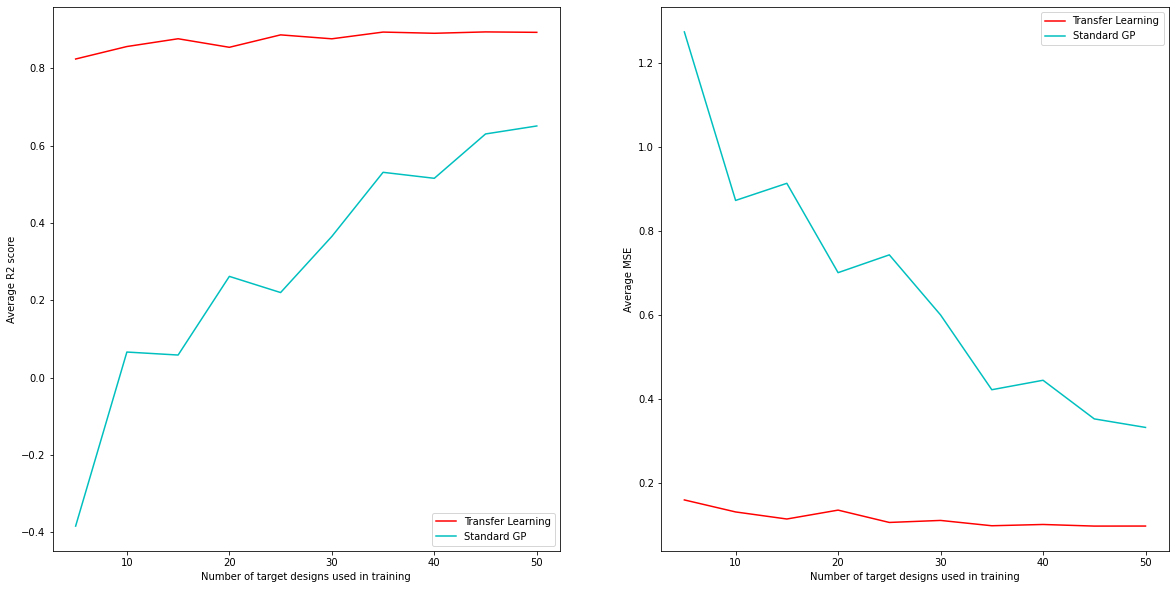

In [41]:
fig,ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1, ax2 = ax

ax1.plot(plot_x_training,y_plot('r2_lin_mf'), c ='r', label='Transfer Learning')
ax1.plot(plot_x_training, y_plot('r2_stand_GP'), c ='c', label='Standard GP')
ax1.set_xlabel('Number of target designs used in training')
ax1.set_ylabel('Average R2 score')
ax1.legend()
    
ax2.plot(plot_x_training, y_plot('mse_lin_mf'), c ='r', label='Transfer Learning')
ax2.plot(plot_x_training, y_plot('mse_stand_GP'), c ='c', label='Standard GP')
ax2.set_xlabel('Number of target designs used in training')
ax2.set_ylabel('Average MSE')
ax2.legend()
#save_fig(f'{name}_ARD_PTB')

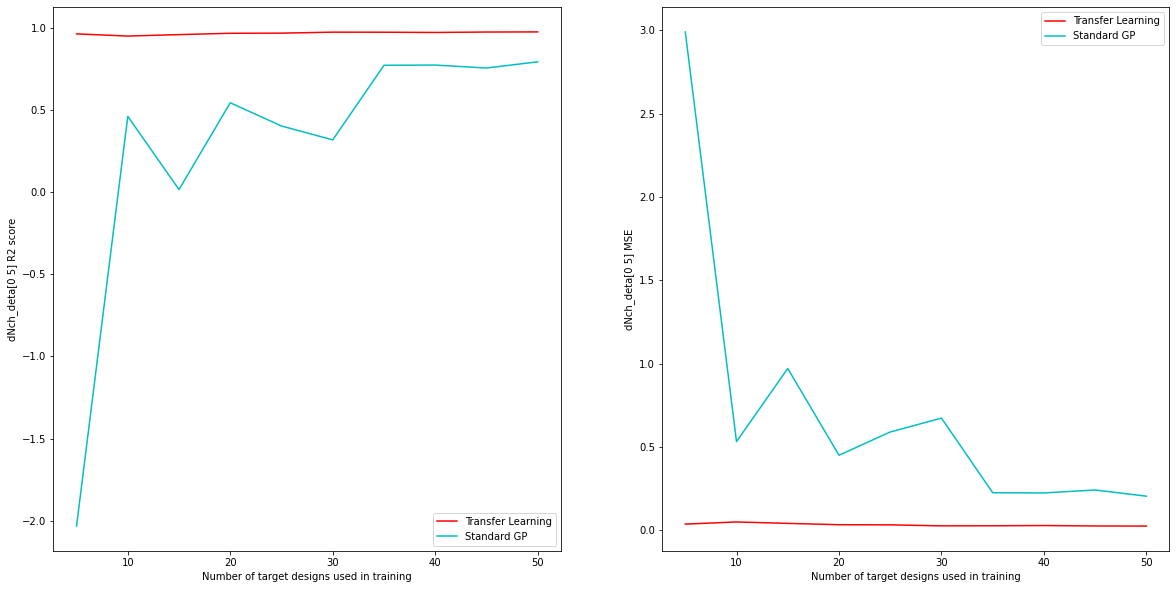

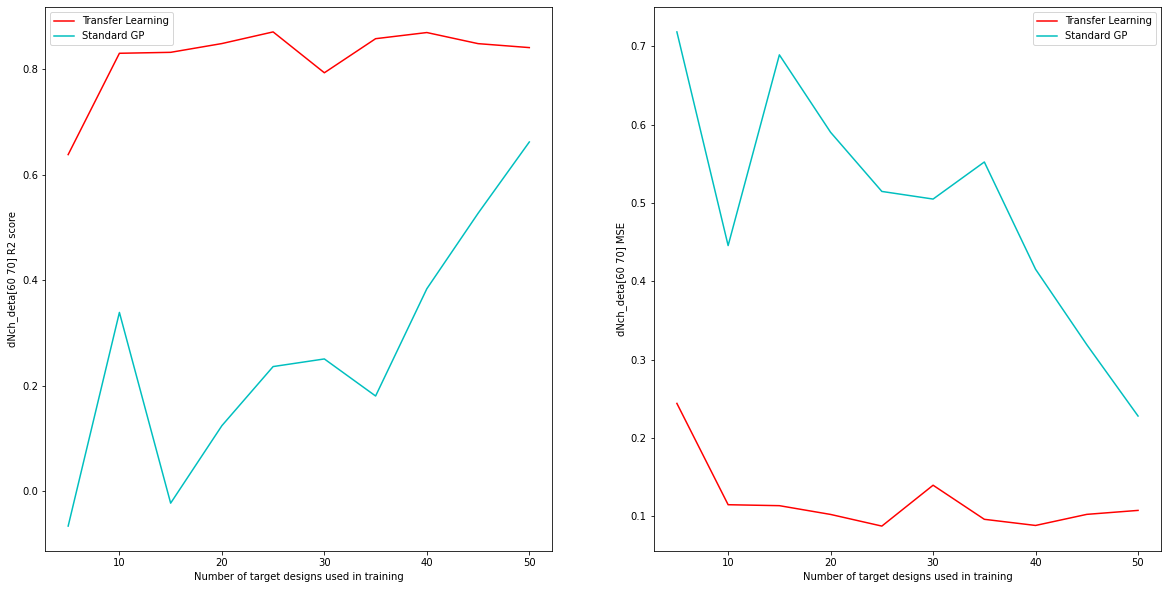

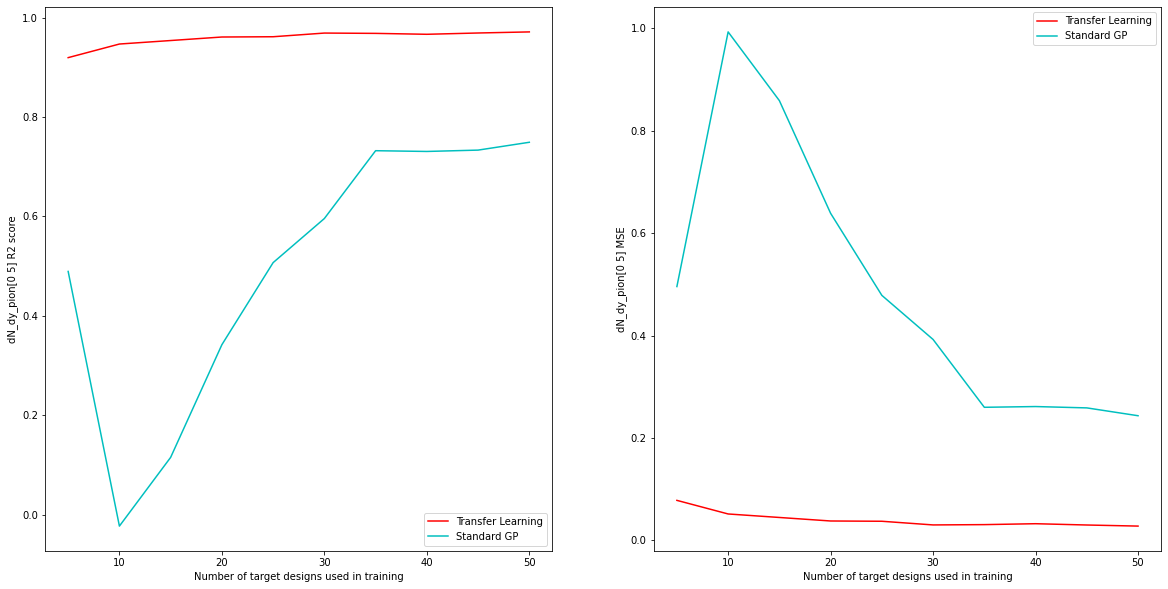

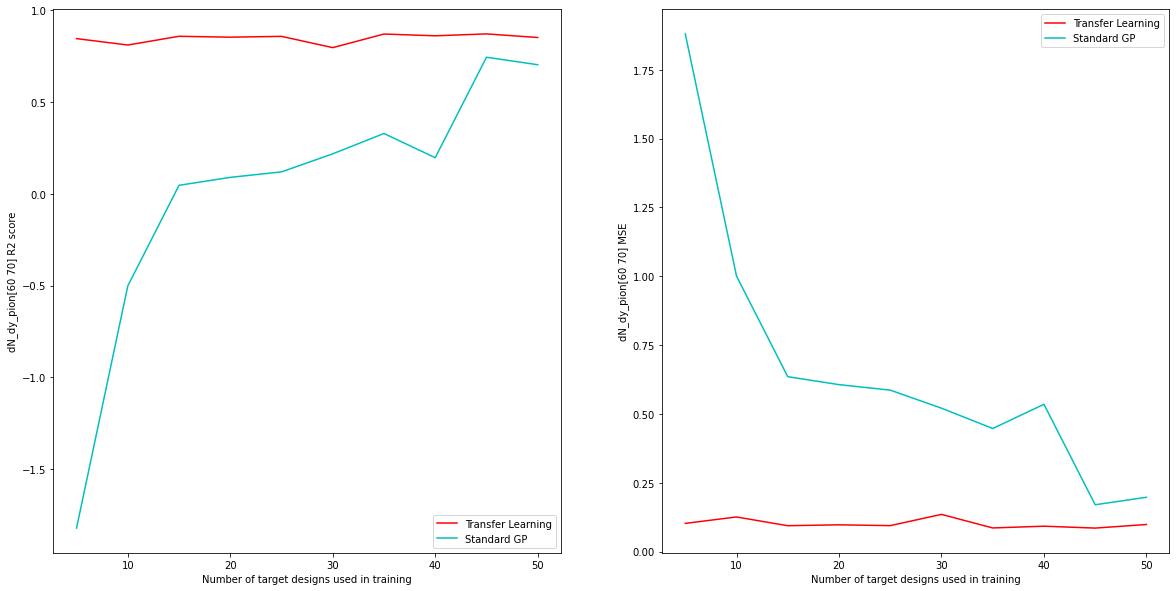

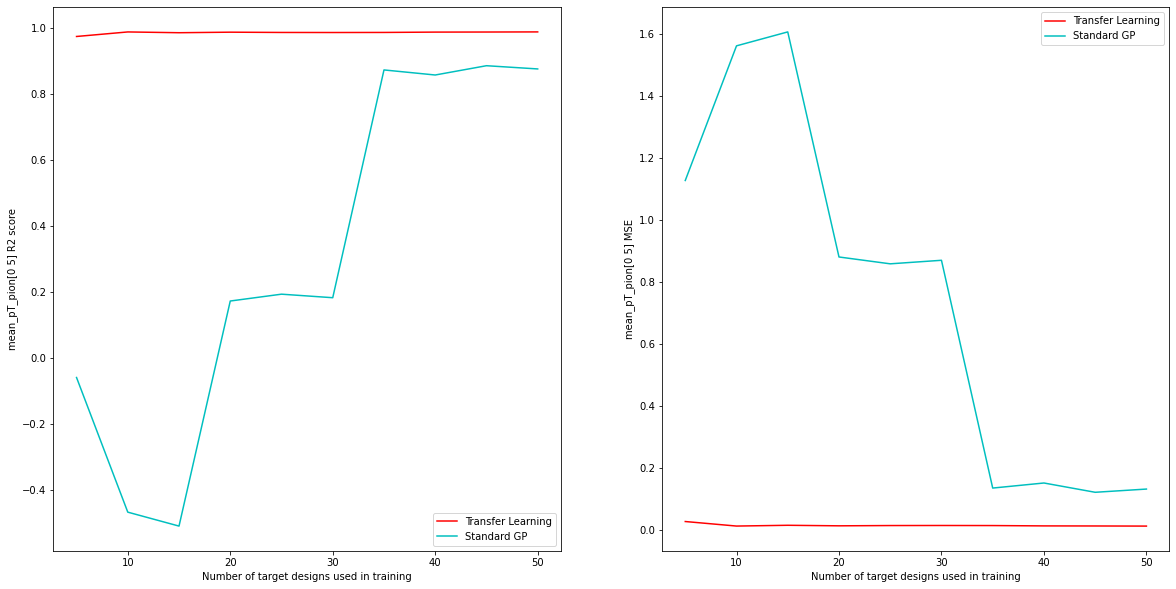

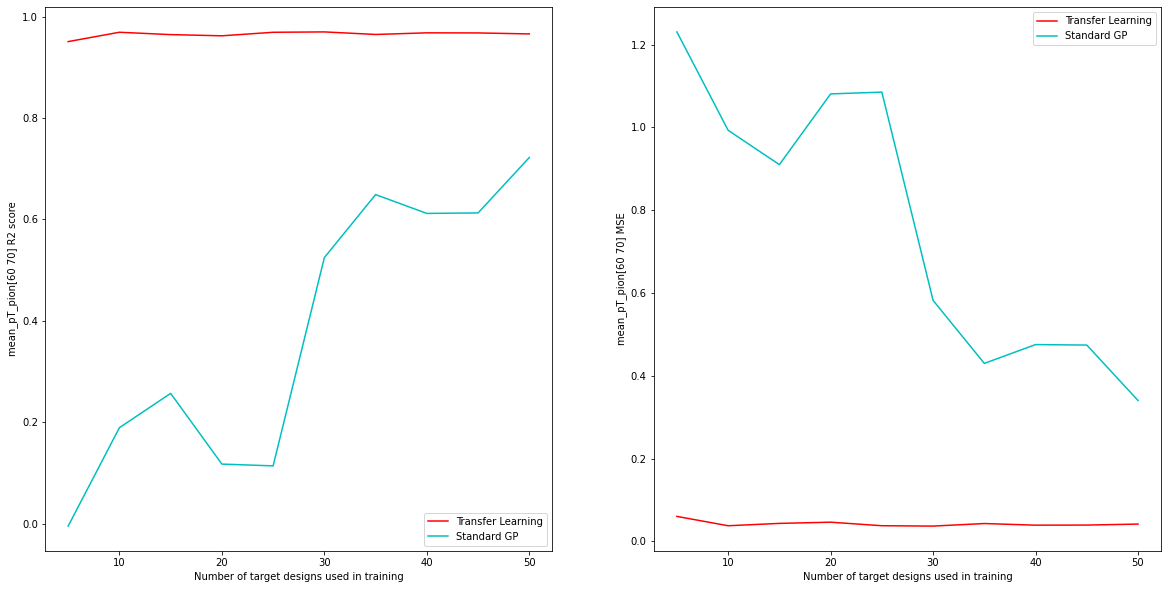

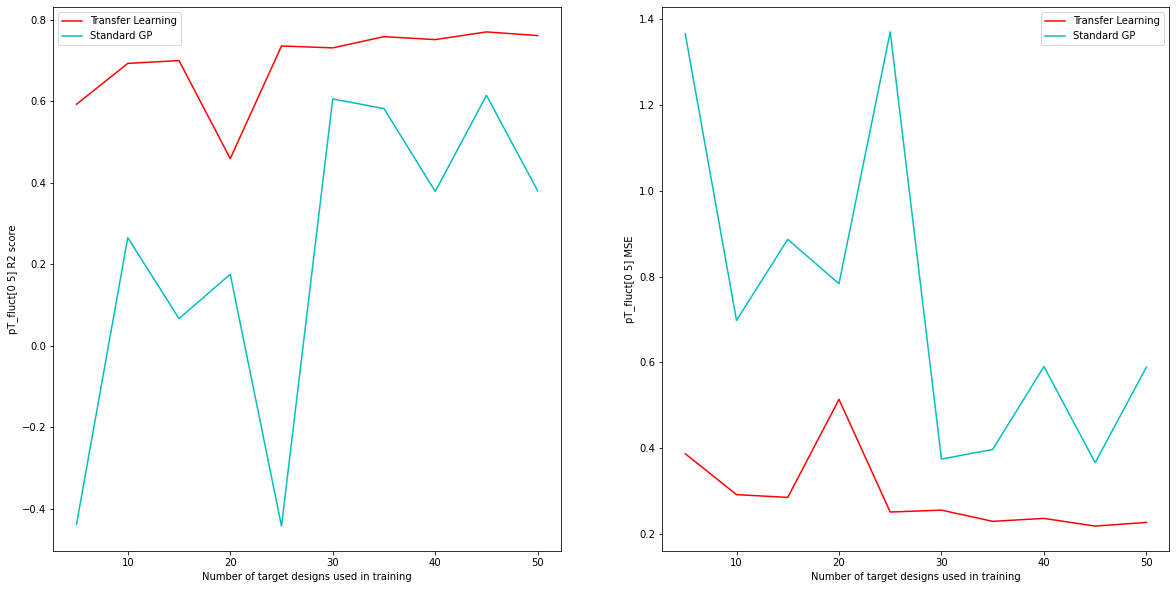

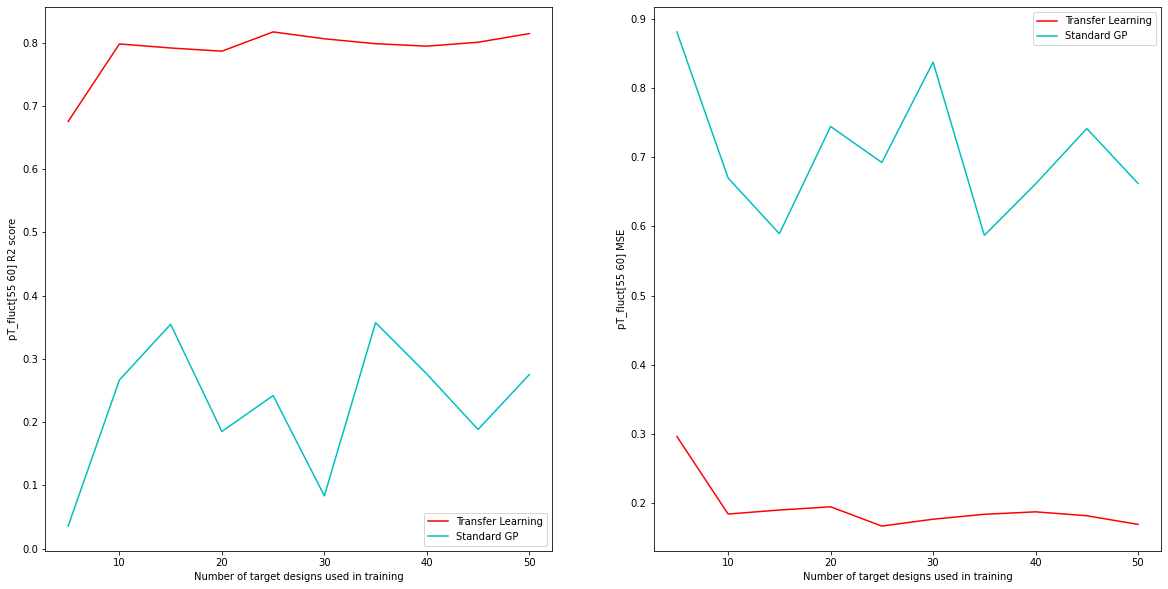

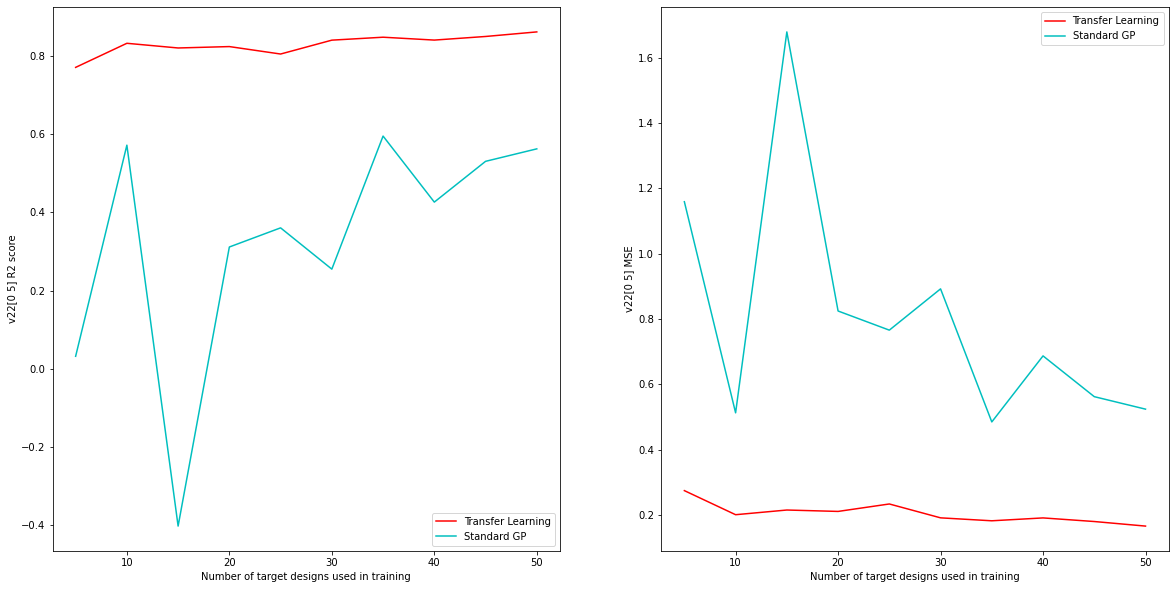

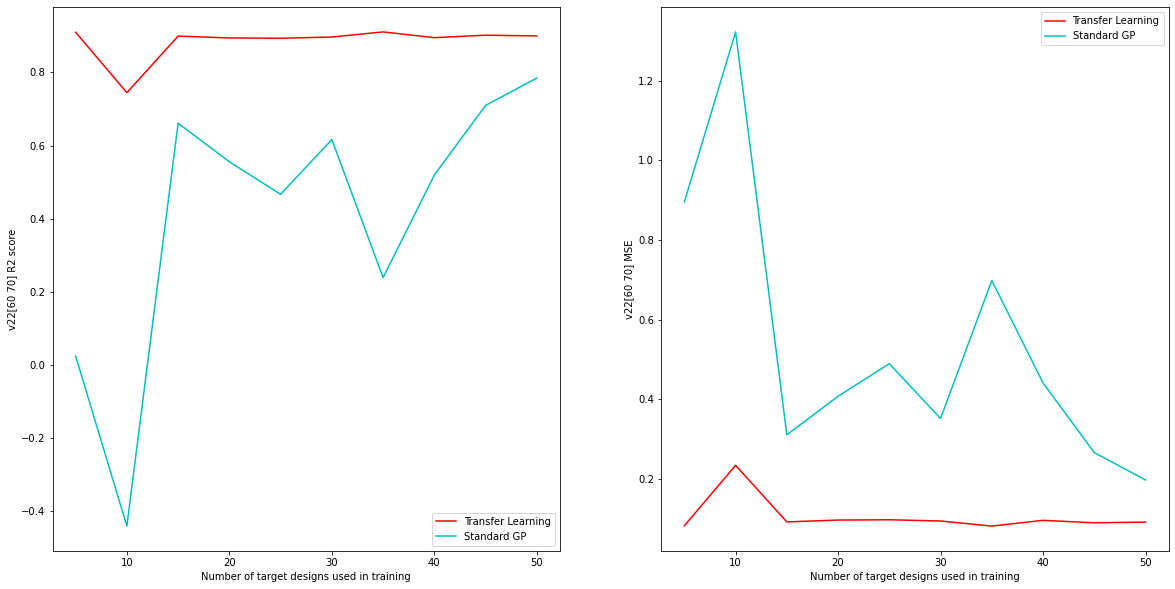

In [42]:
for obs in observables_choosen:
    fig,ax =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax1, ax2 = ax
    ax1.plot(plot_x_training,y_plot_obs('r2_lin_mf',obs), c ='r', label='Transfer Learning')
    ax1.plot(plot_x_training,y_plot_obs('r2_stand_GP',obs),c ='c', label='Standard GP')
    ax1.set_xlabel('Number of target designs used in training')
    ax1.set_ylabel(f'{obs} R2 score')
    ax1.legend()

    ax2.plot(plot_x_training,y_plot_obs('mse_lin_mf',obs), c ='r', label='Transfer Learning')
    ax2.plot(plot_x_training,y_plot_obs('mse_stand_GP',obs), c ='c', label='Standard GP')
    ax2.set_xlabel('Number of target designs used in training')
    ax2.set_ylabel(f'{obs} MSE')
    ax2.legend()
    #save_fig(f'{name}_ARD_PTB')